# Librerias

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0, ResNet50, EfficientNetB4, EfficientNetB5, MobileNetV2, InceptionV3, Xception, MobileNetV3Large
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, legacy as legacy_optimizers
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.layers import BatchNormalization
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

import wandb
from wandb.integration.keras import WandbCallback
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.keras import TqdmCallback  # Importamos el callback de TQDM
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

# Clasificación 6 Clases

## Dataset

In [2]:
# import numpy as np
# from sklearn.model_selection import train_test_split
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# import pandas as pd
# import os
# import shutil

# # Directorio de las imágenes originales
# data_dir = 'crops_90x90'

# # Directorio de salida para las imágenes divididas en 6 clases
# output_dir = 'crops_90x90_6clases'  # Cambiado a 6 clases
# train_dir = os.path.join(output_dir, 'train')
# val_dir = os.path.join(output_dir, 'val')
# test_dir = os.path.join(output_dir, 'test')

# # Crear las carpetas de entrenamiento, validación y prueba si no existen
# os.makedirs(train_dir, exist_ok=True)
# os.makedirs(val_dir, exist_ok=True)
# os.makedirs(test_dir, exist_ok=True)

# # Definir las 6 clases
# classes = ['Negative', 'HSIL', 'LSIL', 'ASC-H', 'ASC-US', 'SCC']

# # Crear subcarpetas para cada clase dentro de train, val y test
# for split_dir in [train_dir, val_dir, test_dir]:
#     for class_name in classes:
#         os.makedirs(os.path.join(split_dir, class_name), exist_ok=True)

# # Configuración del generador de imágenes
# datagen = ImageDataGenerator(rescale=1./255)

# # Cargar todas las imágenes y sus etiquetas desde el directorio original
# all_images_generator = datagen.flow_from_directory(
#     data_dir,
#     target_size=(90, 90),
#     batch_size=32,
#     class_mode='categorical',  # Multiclase
#     classes=classes,
#     shuffle=False  # No mezclar para mantener la correspondencia entre imágenes y etiquetas
# )

# # Obtener los paths de los archivos y las etiquetas numéricas
# filepaths = all_images_generator.filepaths
# labels = all_images_generator.classes  # Etiquetas numéricas

# # Obtener el mapeo de índices a nombres de clase
# class_indices = all_images_generator.class_indices
# index_to_class = {v: k for k, v in class_indices.items()}

# # Crear un DataFrame para facilitar la manipulación de datos
# df = pd.DataFrame({
#     'filename': filepaths,
#     'label': labels
# })

# # Dividir el dataset en entrenamiento (70%), validación (15%) y prueba (15%)
# train_files, temp_files, train_labels, temp_labels = train_test_split(
#     df['filename'], df['label'], test_size=0.30, stratify=df['label'], random_state=42
# )
# val_files, test_files, val_labels, test_labels = train_test_split(
#     temp_files, temp_labels, test_size=0.50, stratify=temp_labels, random_state=42
# )

# # Función para crear enlaces simbólicos a las imágenes en las carpetas correspondientes
# def create_symlinks(filepaths, labels, dest_dir, index_to_class):
#     for filepath, label in zip(filepaths, labels):
#         class_name = index_to_class[label]  # Obtener el nombre de la clase
#         dest_subfolder = class_name
#         dest_path = os.path.join(dest_dir, dest_subfolder, os.path.basename(filepath))
        
#         # Verificar si el enlace ya existe
#         if not os.path.exists(dest_path):
#             try:
#                 os.symlink(os.path.abspath(filepath), dest_path)
#             except OSError as e:
#                 print(f"Error al crear el enlace simbólico para {filepath}: {e}")

# # Copiar (crear enlaces) las imágenes a las carpetas de entrenamiento, validación y prueba
# create_symlinks(train_files, train_labels, train_dir, index_to_class)
# create_symlinks(val_files, val_labels, val_dir, index_to_class)
# create_symlinks(test_files, test_labels, test_dir, index_to_class)

# # Imprimir el resultado de la división
# print(f"Total de imágenes en entrenamiento: {len(train_files)}")
# print(f"Total de imágenes en validación: {len(val_files)}")
# print(f"Total de imágenes en prueba: {len(test_files)}")


Found 11534 images belonging to 6 classes.
Total de imágenes en entrenamiento: 8073
Total de imágenes en validación: 1730
Total de imágenes en prueba: 1731


### Distribución de clases

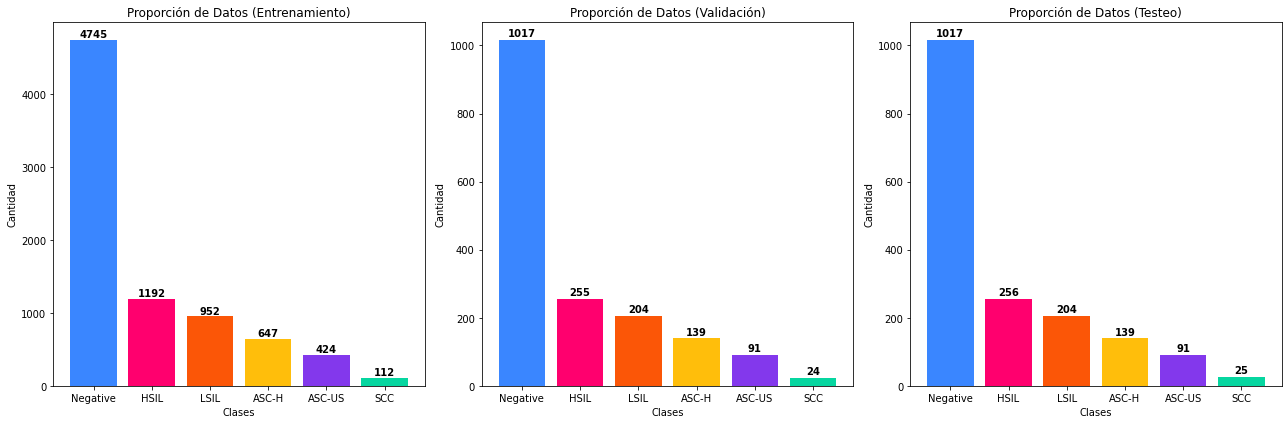

In [124]:
import os
import matplotlib.pyplot as plt
from collections import defaultdict

# Función para contar imágenes en cada subclase dentro de '1_lesion' y '0_no_lesion'
def count_images_in_folders(base_folder):
    class_counts = defaultdict(int)
    for lesion_type in os.listdir(base_folder):
        lesion_path = os.path.join(base_folder, lesion_type)
        if os.path.isdir(lesion_path):
            for class_name in os.listdir(lesion_path):
                class_path = os.path.join(lesion_path, class_name)
                if os.path.isdir(class_path):
                    class_counts[class_name] += len(os.listdir(class_path))
    return dict(class_counts)

# Función para graficar las proporciones de las clases
def plot_class_proportion_subplot(ax, class_counts, title):
    ax.bar(class_counts.keys(), class_counts.values(), color=['#3A86FF', '#FF006E', '#FB5607', '#FFBE0B', '#8338EC', '#06D6A0'])
    ax.set_xlabel('Clases')
    ax.set_ylabel('Cantidad')
    ax.set_title(title)
    
    # Agregar etiquetas de cantidad sobre las barras
    for i, (class_name, count) in enumerate(class_counts.items()):
        ax.text(i, count + 5, str(count), ha='center', va='bottom', fontweight='bold')

# Directorios donde se encuentran las imágenes de entrenamiento y prueba
train_dir = 'imagenes_divididas/train/'
val_dir = 'imagenes_divididas/val'
test_dir = 'imagenes_divididas/test'

# Contar las imágenes en cada conjunto
train_class_counts = count_images_in_folders(train_dir)
val_class_counts = count_images_in_folders(val_dir)
test_class_counts = count_images_in_folders(test_dir)

# Crear gráficos para los conjuntos de entrenamiento y prueba
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 fila, 2 columnas

# Gráfico para entrenamiento
plot_class_proportion_subplot(axes[0], train_class_counts, 'Proporción de Datos (Entrenamiento)')

# Gráfico para validación
plot_class_proportion_subplot(axes[1], val_class_counts, 'Proporción de Datos (Validación)')

# Gráfico para prueba
plot_class_proportion_subplot(axes[2], test_class_counts, 'Proporción de Datos (Testeo)')

# Ajustar el espaciado entre los subplots
plt.tight_layout()
plt.show()

# Modelos

## Generador

Crea un directorio temporal (temp_imagenes_divididas) donde se replican las clases de 0_no_lesion y 1_lesion en un formato que ImageDataGenerator puede interpretar directamente como 6 clases.

In [3]:
import os
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Directorios base originales
base_dir = 'imagenes_divididas'
train_original = os.path.join(base_dir, 'train')
val_original = os.path.join(base_dir, 'val')
test_original = os.path.join(base_dir, 'test')

# Directorio temporal para la nueva estructura de clases
temp_dir = 'temp_imagenes_divididas'
train_dir = os.path.join(temp_dir, 'train')
val_dir = os.path.join(temp_dir, 'val')
test_dir = os.path.join(temp_dir, 'test')

# Clases dentro de "1_lesion"
lesion_classes = ['ASC-H', 'ASC-US', 'HSIL', 'LSIL', 'SCC']

def create_temp_structure_copy(original_dir, new_dir):
    os.makedirs(new_dir, exist_ok=True)
    
    # Copiar imágenes para "0_no_lesion/Negative"
    negative_src = os.path.join(original_dir, '0_no_lesion', 'Negative')
    negative_dest = os.path.join(new_dir, 'Negative')
    os.makedirs(negative_dest, exist_ok=True)
    for img in os.listdir(negative_src):
        src_path = os.path.join(negative_src, img)
        dest_path = os.path.join(negative_dest, img)
        if not os.path.exists(dest_path):
            shutil.copy(src_path, dest_path)  # Copiar archivo

    # Copiar imágenes para las subclases de "1_lesion"
    for lesion_class in lesion_classes:
        class_src = os.path.join(original_dir, '1_lesion', lesion_class)
        class_dest = os.path.join(new_dir, lesion_class)
        os.makedirs(class_dest, exist_ok=True)
        for img in os.listdir(class_src):
            src_path = os.path.join(class_src, img)
            dest_path = os.path.join(class_dest, img)
            if not os.path.exists(dest_path):
                shutil.copy(src_path, dest_path)  # Copiar archivo

# Crear la estructura de directorios temporales copiando los archivos
create_temp_structure_copy(train_original, train_dir)
create_temp_structure_copy(val_original, val_dir)
create_temp_structure_copy(test_original, test_dir)


In [152]:
# Configuración del generador de datos
IMG_HEIGHT, IMG_WIDTH = 90, 90
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# Generadores con la nueva estructura de 6 clases
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)
val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 8072 images belonging to 6 classes.
Found 1730 images belonging to 6 classes.
Found 1732 images belonging to 6 classes.


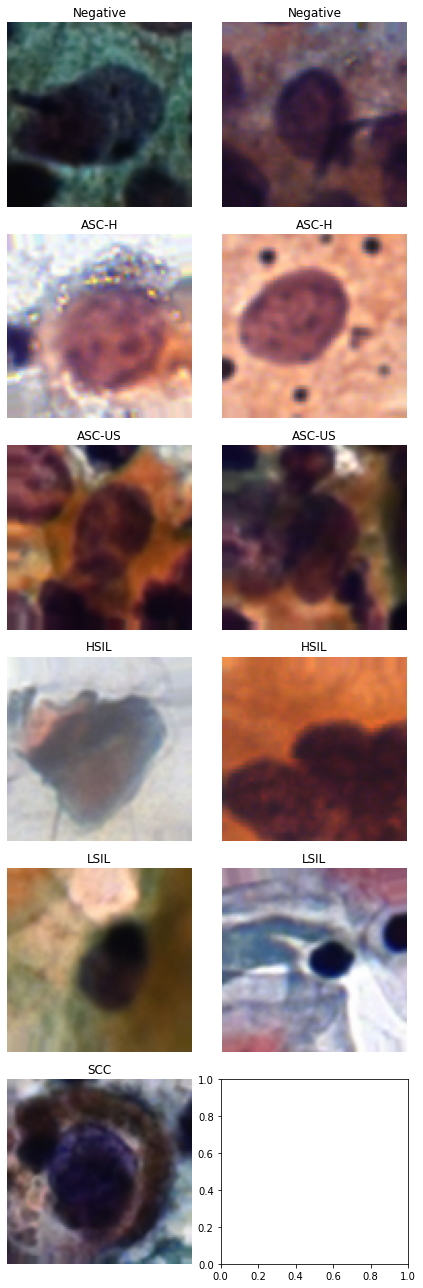

In [158]:
import matplotlib.pyplot as plt
import numpy as np

def mostrar_imagenes_por_clase(generator, class_labels, num_por_clase=2):
    """
    Visualiza imágenes del generador asegurando que los valores estén en [0, 1].
    """
    # Obtener un lote de imágenes y etiquetas
    images, labels = next(generator)

    # Asegurar que las etiquetas sean índices (en caso de one-hot encoding)
    labels = np.argmax(labels, axis=1)

    # # Reescalar si los valores son demasiado bajos (ya divididos por 255 dos veces)
    if images.max() <= 0.01:
        print("Reescalando las imágenes para visualización...")
        images *= 255

    # Crear la figura y ejes
    fig, axes = plt.subplots(len(class_labels), num_por_clase, 
                             figsize=(num_por_clase * 3, len(class_labels) * 3))

    # Iterar sobre cada clase y visualizar las imágenes
    for class_index, class_name in enumerate(class_labels):
        # Encontrar las imágenes que pertenecen a la clase actual
        class_indices = np.where(labels == class_index)[0]

        # Asegurarse de que haya suficientes imágenes para mostrar
        num_imagenes = min(num_por_clase, len(class_indices))

        for i in range(num_imagenes):
            img_index = class_indices[i]
            ax = axes[class_index, i]

            # Mostrar la imagen
            ax.imshow(images[img_index])
            ax.set_title(f"{class_name}")
            ax.axis("off")

    plt.tight_layout()
    plt.show()

# Definir los nombres de las clases
class_labels = ['Negative', 'ASC-H', 'ASC-US', 'HSIL', 'LSIL', 'SCC']

# Mostrar imágenes del generador de entrenamiento
mostrar_imagenes_por_clase(train_generator, class_labels, num_por_clase=2)

In [148]:
import os

def verificar_enlaces_simetricos(directorio):
    for root, _, files in os.walk(directorio):
        for file in files:
            path = os.path.join(root, file)
            if os.path.islink(path):
                if not os.path.exists(os.readlink(path)):
                    print(f"Enlace roto: {path}")

verificar_enlaces_simetricos(temp_dir)


## Modelo EfficientNetB0

In [159]:
# Definición del modelo EfficientNetB0
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model.trainable = True
fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base_model(inputs, training=True)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(NUM_CLASSES, activation='softmax')(x)
model = Model(inputs, outputs)

model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy',
                    tf.keras.metrics.Precision(name='precision'), 
                    tf.keras.metrics.Recall(name='recall'), 
                    tf.keras.metrics.AUC(name='auc'),
                    tf.keras.metrics.AUC(name='f1_score')])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6)

# Entrenamiento con barra de progreso
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr]  # Barra de progreso
)

Epoch 1/20


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


253/253 ━━━━━━━━━━━━━━━━━━━━ 49s 162ms/step - accuracy: 0.5217 - auc: 0.7766 - f1_score: 0.7766 - loss: 1.4200 - precision: 0.5719 - recall: 0.3003 - val_accuracy: 0.5879 - val_auc: 0.8209 - val_f1_score: 0.8209 - val_loss: 1.3227 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 41s 162ms/step - accuracy: 0.5897 - auc: 0.8455 - f1_score: 0.8455 - loss: 1.2158 - precision: 0.6773 - recall: 0.4167 - val_accuracy: 0.5879 - val_auc: 0.7813 - val_f1_score: 0.7813 - val_loss: 2.0929 - val_precision: 0.5879 - val_recall: 0.5879 - learning_rate: 1.0000e-04
Epoch 3/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 41s 162ms/step - accuracy: 0.6259 - auc: 0.8731 - f1_score: 0.8731 - loss: 1.1079 - precision: 0.7214 - recall: 0.4673 - val_accuracy: 0.5879 - val_auc: 0.7892 - val_f1_score: 0.7892 - val_loss: 2.1391 - val_precision: 0.5879 - val_recall: 0.5879 - learning_rate: 1.0000e-04
Epoch 4/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 41s 161ms/step - a

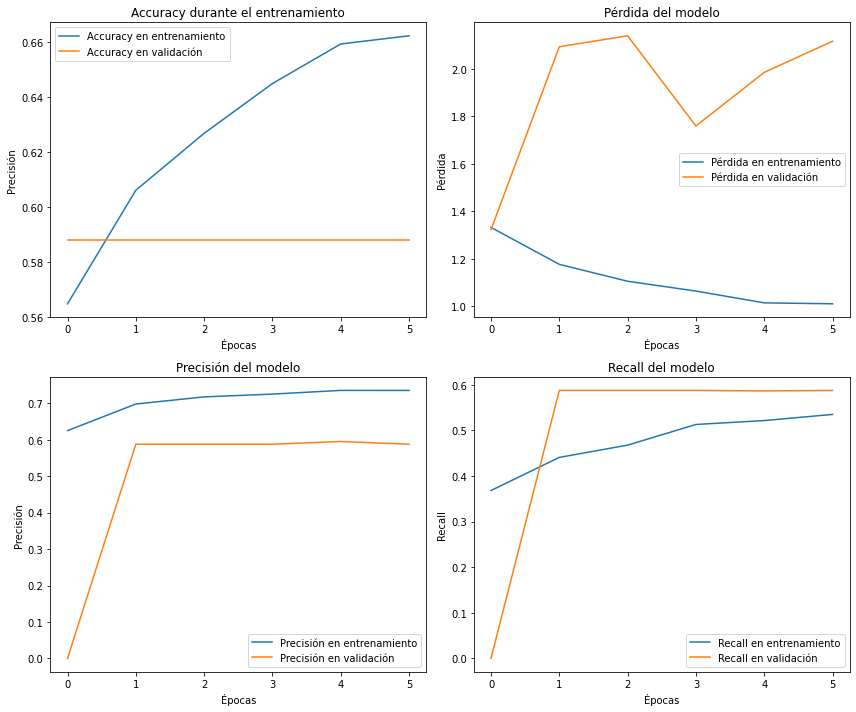

In [160]:
import matplotlib.pyplot as plt

# Establecer una figura para alojar los gráficos
plt.figure(figsize=(12, 10))  # Ajusta el tamaño según tus preferencias

# Gráfica de accuracy
plt.subplot(2, 2, 1)  # 2 filas, 2 columnas, primer gráfico
plt.plot(history.history['accuracy'], label='Accuracy en entrenamiento')
plt.plot(history.history['val_accuracy'], label='Accuracy en validación')
plt.title('Accuracy durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfica de pérdida
plt.subplot(2, 2, 2)  # 2 filas, 2 columnas, segundo gráfico
plt.plot(history.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en validación')
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Gráfica de precisión
plt.subplot(2, 2, 3)  # 2 filas, 2 columnas, tercer gráfico
plt.plot(history.history['precision'], label='Precisión en entrenamiento')
plt.plot(history.history['val_precision'], label='Precisión en validación')
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfica de recall
plt.subplot(2, 2, 4)  # 2 filas, 2 columnas, cuarto gráfico
plt.plot(history.history['recall'], label='Recall en entrenamiento')
plt.plot(history.history['val_recall'], label='Recall en validación')
plt.title('Recall del modelo')
plt.xlabel('Épocas')
plt.ylabel('Recall')
plt.legend()

# Mostrar los gráficos
plt.tight_layout()  # Ajusta el espacio entre los gráficos
plt.show()

### Evaluación

In [161]:
# Evaluar el rendimiento del modelo en el conjunto de prueba
test_loss, test_acc, test_precision, test_recall, test_auc, test_f1 = model.evaluate(
    test_generator,  # Generador del conjunto de prueba
)

# Imprimir los resultados
print(f'Pérdida en el conjunto de prueba: {test_loss}')
print(f'accuracy en el conjunto de prueba: {test_acc}')
print(f'Precision en el conjunto de prueba: {test_precision}')
print(f'Recall en el conjunto de prueba: {test_recall}')
print(f'AUC en el conjunto de prueba: {test_auc}')
print(f'F1-Score en el conjunto de prueba: {test_f1}')

55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.2519 - auc: 0.6402 - f1_score: 0.6402 - loss: 1.7670 - precision: 0.0000e+00 - recall: 0.0000e+00
Pérdida en el conjunto de prueba: 1.3241541385650635
accuracy en el conjunto de prueba: 0.5871824622154236
Precision en el conjunto de prueba: 0.0
Recall en el conjunto de prueba: 0.0
AUC en el conjunto de prueba: 0.8187069892883301
F1-Score en el conjunto de prueba: 0.8187069892883301


55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step


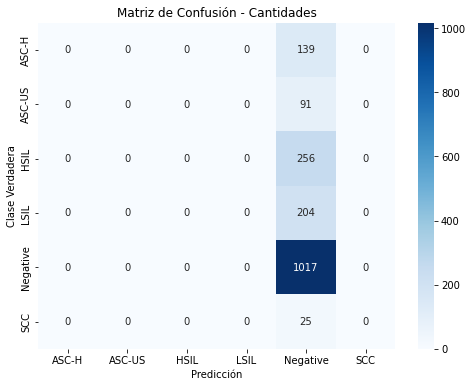

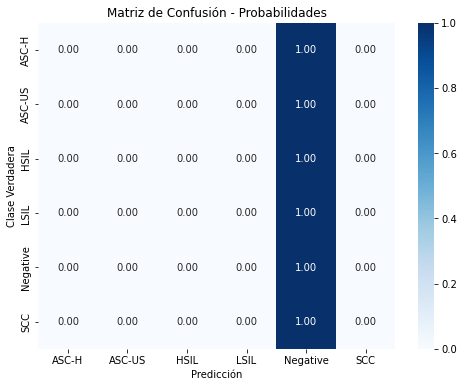

              precision    recall  f1-score   support

       ASC-H       0.00      0.00      0.00       139
      ASC-US       0.00      0.00      0.00        91
        HSIL       0.00      0.00      0.00       256
        LSIL       0.00      0.00      0.00       204
    Negative       0.59      1.00      0.74      1017
         SCC       0.00      0.00      0.00        25

    accuracy                           0.59      1732
   macro avg       0.10      0.17      0.12      1732
weighted avg       0.34      0.59      0.43      1732



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

In [162]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Realizar predicciones en el conjunto de prueba
test_steps = int(np.ceil(test_generator.samples / test_generator.batch_size))
predictions = model.predict(test_generator, steps=test_steps)
predicted_classes = np.argmax(predictions, axis=1)

# Obtener las etiquetas verdaderas
true_classes = test_generator.classes

# Obtener las clases
class_labels = list(test_generator.class_indices.keys())

# Crear la matriz de confusión
cm = confusion_matrix(true_classes, predicted_classes)

# Crear la matriz de confusión normalizada (probabilidades)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Función para graficar la matriz de confusión
def plot_confusion_matrix(cm, class_labels, title='Matriz de Confusión', cmap='Blues', fmt='d'):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap=cmap, xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicción')
    plt.ylabel('Clase Verdadera')
    plt.title(title)
    plt.show()

# Graficar la matriz de confusión con cantidades
plot_confusion_matrix(cm, class_labels, title='Matriz de Confusión - Cantidades')

# Graficar la matriz de confusión con probabilidades
plot_confusion_matrix(cm_normalized, class_labels, title='Matriz de Confusión - Probabilidades', fmt='.2f')

# Reporte de clasificación
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step


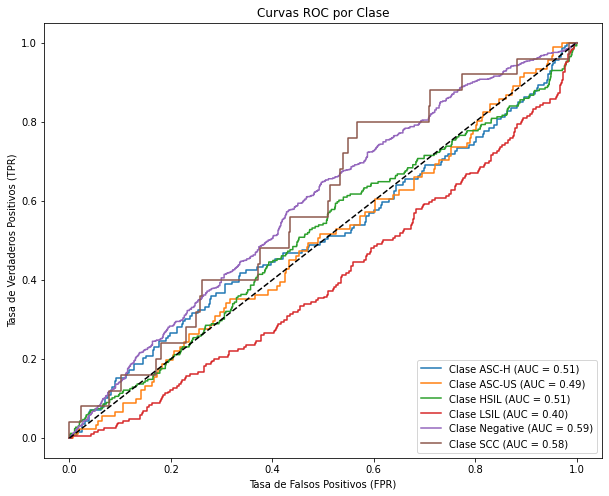

AUC Promedio: 0.51
AUC Promedio Ponderado: 0.54


In [163]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

# Obtener las probabilidades predichas
y_pred_proba = model.predict(test_generator)

# Obtener las etiquetas verdaderas y nombres de las clases
y_true = test_generator.classes  # Etiquetas verdaderas
class_names = list(test_generator.class_indices.keys())  # Nombres de las clases

# Convertir y_true a formato binario por clase
n_classes = len(class_names)
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))


roc_auc = dict()

# Generar curvas ROC para cada clase
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Clase {class_names[i]} (AUC = {auc(fpr, tpr):.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Línea de referencia
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC por Clase')
plt.legend(loc='lower right')
plt.show()

# Calcular y mostrar el AUC promedio
auc_promedio = np.mean(list(roc_auc.values()))
print(f'AUC Promedio: {auc_promedio:.2f}')

# Calcular y mostrar el AUC promedio ponderado
auc_promedio_pond = roc_auc_score(y_true_bin, y_pred_proba, average='weighted', multi_class='ovr')
print(f'AUC Promedio Ponderado: {auc_promedio_pond:.2f}')

## Modelo EfficientNetB4

In [164]:
# Cargar el modelo base EfficientNetB4 preentrenado
base_model = EfficientNetB4(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Descongelar todas las capas excepto las primeras 100 capas
base_model.trainable = True
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base_model(inputs, training=True)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs, outputs)

model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy',
                    tf.keras.metrics.Precision(name='precision'), 
                    tf.keras.metrics.Recall(name='recall'), 
                    tf.keras.metrics.AUC(name='auc'),
                    tf.keras.metrics.AUC(name='f1_score')])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)

# Entrenamiento del modelo
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 186s 649ms/step - accuracy: 0.5106 - auc: 0.7892 - f1_score: 0.7892 - loss: 1.3853 - precision: 0.6678 - recall: 0.2713 - val_accuracy: 0.5879 - val_auc: 0.8365 - val_f1_score: 0.8365 - val_loss: 1.2900 - val_precision: 0.6480 - val_recall: 0.0671 - learning_rate: 1.0000e-04
Epoch 2/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 153s 602ms/step - accuracy: 0.5993 - auc: 0.8634 - f1_score: 0.8634 - loss: 1.1451 - precision: 0.7475 - recall: 0.4212 - val_accuracy: 0.6006 - val_auc: 0.8930 - val_f1_score: 0.8930 - val_loss: 1.1343 - val_precision: 0.6473 - val_recall: 0.5728 - learning_rate: 1.0000e-04
Epoch 3/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 147s 580ms/step - accuracy: 0.6284 - auc: 0.8872 - f1_score: 0.8872 - loss: 1.0463 - precision: 0.7654 - recall: 0.4778 - val_accuracy: 0.6792 - val_auc: 0.9208 - val_f1_score: 0.9208 - val_loss: 0.8825 - val_precision: 0.8041 - val_recall: 0.5457 - learning_rate: 1.0000e-04
Epoch 4/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 159s 626ms/s

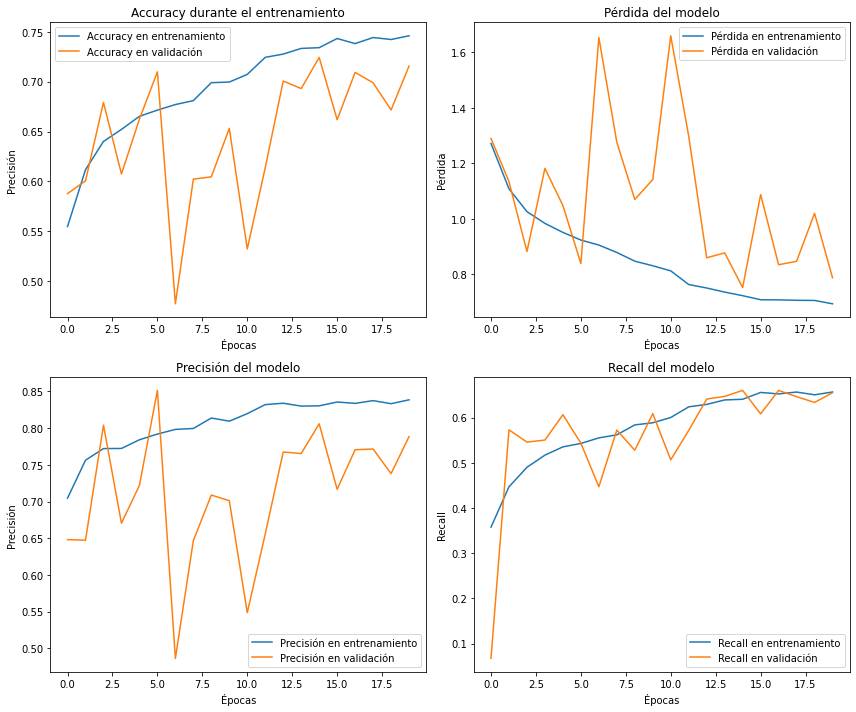

In [165]:
import matplotlib.pyplot as plt

# Establecer una figura para alojar los gráficos
plt.figure(figsize=(12, 10))  # Ajusta el tamaño según tus preferencias

# Gráfica de accuracy
plt.subplot(2, 2, 1)  # 2 filas, 2 columnas, primer gráfico
plt.plot(history.history['accuracy'], label='Accuracy en entrenamiento')
plt.plot(history.history['val_accuracy'], label='Accuracy en validación')
plt.title('Accuracy durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfica de pérdida
plt.subplot(2, 2, 2)  # 2 filas, 2 columnas, segundo gráfico
plt.plot(history.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en validación')
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Gráfica de precisión
plt.subplot(2, 2, 3)  # 2 filas, 2 columnas, tercer gráfico
plt.plot(history.history['precision'], label='Precisión en entrenamiento')
plt.plot(history.history['val_precision'], label='Precisión en validación')
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfica de recall
plt.subplot(2, 2, 4)  # 2 filas, 2 columnas, cuarto gráfico
plt.plot(history.history['recall'], label='Recall en entrenamiento')
plt.plot(history.history['val_recall'], label='Recall en validación')
plt.title('Recall del modelo')
plt.xlabel('Épocas')
plt.ylabel('Recall')
plt.legend()

# Mostrar los gráficos
plt.tight_layout()  # Ajusta el espacio entre los gráficos
plt.show()

### Evaluación

In [166]:
# Evaluar el rendimiento del modelo en el conjunto de prueba
test_loss, test_acc, test_precision, test_recall, test_auc, test_f1 = model.evaluate(
    test_generator,  # Generador del conjunto de prueba
)

# Imprimir los resultados
print(f'Pérdida en el conjunto de prueba: {test_loss}')
print(f'accuracy en el conjunto de prueba: {test_acc}')
print(f'Precision en el conjunto de prueba: {test_precision}')
print(f'Recall en el conjunto de prueba: {test_recall}')
print(f'AUC en el conjunto de prueba: {test_auc}')
print(f'F1-Score en el conjunto de prueba: {test_f1}')

55/55 ━━━━━━━━━━━━━━━━━━━━ 9s 164ms/step - accuracy: 0.5075 - auc: 0.8385 - f1_score: 0.8385 - loss: 1.2627 - precision: 0.5545 - recall: 0.4214
Pérdida en el conjunto de prueba: 0.7649876475334167
accuracy en el conjunto de prueba: 0.7269052863121033
Precision en el conjunto de prueba: 0.7988904118537903
Recall en el conjunto de prueba: 0.6651270389556885
AUC en el conjunto de prueba: 0.9412828683853149
F1-Score en el conjunto de prueba: 0.9412828683853149


55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 195ms/step


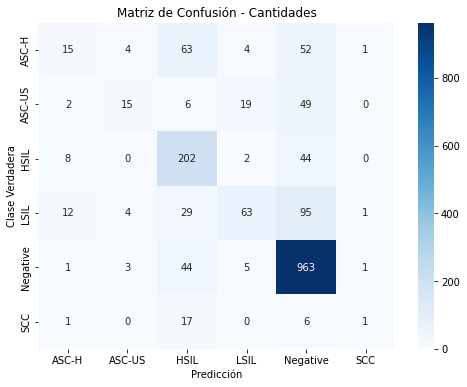

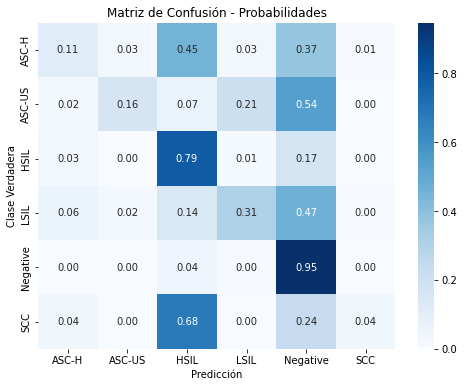

              precision    recall  f1-score   support

       ASC-H       0.38      0.11      0.17       139
      ASC-US       0.58      0.16      0.26        91
        HSIL       0.56      0.79      0.65       256
        LSIL       0.68      0.31      0.42       204
    Negative       0.80      0.95      0.87      1017
         SCC       0.25      0.04      0.07        25

    accuracy                           0.73      1732
   macro avg       0.54      0.39      0.41      1732
weighted avg       0.69      0.73      0.68      1732



In [167]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Realizar predicciones en el conjunto de prueba
test_steps = int(np.ceil(test_generator.samples / test_generator.batch_size))
predictions = model.predict(test_generator, steps=test_steps)
predicted_classes = np.argmax(predictions, axis=1)

# Obtener las etiquetas verdaderas
true_classes = test_generator.classes

# Obtener las clases
class_labels = list(test_generator.class_indices.keys())

# Crear la matriz de confusión
cm = confusion_matrix(true_classes, predicted_classes)

# Crear la matriz de confusión normalizada (probabilidades)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Función para graficar la matriz de confusión
def plot_confusion_matrix(cm, class_labels, title='Matriz de Confusión', cmap='Blues', fmt='d'):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap=cmap, xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicción')
    plt.ylabel('Clase Verdadera')
    plt.title(title)
    plt.show()

# Graficar la matriz de confusión con cantidades
plot_confusion_matrix(cm, class_labels, title='Matriz de Confusión - Cantidades')

# Graficar la matriz de confusión con probabilidades
plot_confusion_matrix(cm_normalized, class_labels, title='Matriz de Confusión - Probabilidades', fmt='.2f')

# Reporte de clasificación
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

55/55 ━━━━━━━━━━━━━━━━━━━━ 9s 166ms/step


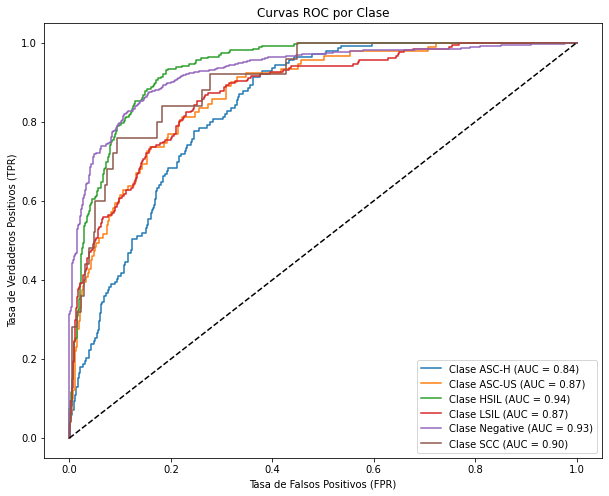

AUC Promedio: 0.89
AUC Promedio Ponderado: 0.91


In [168]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

# Obtener las probabilidades predichas
y_pred_proba = model.predict(test_generator)

# Obtener las etiquetas verdaderas y nombres de las clases
y_true = test_generator.classes  # Etiquetas verdaderas
class_names = list(test_generator.class_indices.keys())  # Nombres de las clases

# Convertir y_true a formato binario por clase
n_classes = len(class_names)
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

roc_auc = dict()

# Generar curvas ROC para cada clase
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Clase {class_names[i]} (AUC = {auc(fpr, tpr):.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Línea de referencia
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC por Clase')
plt.legend(loc='lower right')
plt.show()

# Calcular y mostrar el AUC promedio
auc_promedio = np.mean(list(roc_auc.values()))
print(f'AUC Promedio: {auc_promedio:.2f}')

# Calcular y mostrar el AUC promedio ponderado
auc_promedio_pond = roc_auc_score(y_true_bin, y_pred_proba, average='weighted', multi_class='ovr')
print(f'AUC Promedio Ponderado: {auc_promedio_pond:.2f}')


## Modelo EfficientNetB5

In [169]:
# Cargar el modelo base EfficientNetB4 preentrenado
base_model = EfficientNetB5(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Descongelar todas las capas excepto las primeras 100 capas
base_model.trainable = True
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base_model(inputs, training=True)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs, outputs)


model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy',
                    tf.keras.metrics.Precision(name='precision'), 
                    tf.keras.metrics.Recall(name='recall'), 
                    tf.keras.metrics.AUC(name='auc'),
                    tf.keras.metrics.AUC(name='f1_score')])


# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)

# Entrenamiento del modelo
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 325s 1s/step - accuracy: 0.4742 - auc: 0.7806 - f1_score: 0.7806 - loss: 1.3753 - precision: 0.7357 - recall: 0.2490 - val_accuracy: 0.5902 - val_auc: 0.8746 - val_f1_score: 0.8746 - val_loss: 1.2019 - val_precision: 0.6215 - val_recall: 0.5809 - learning_rate: 1.0000e-04
Epoch 2/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 290s 1s/step - accuracy: 0.6635 - auc: 0.9053 - f1_score: 0.9053 - loss: 0.9611 - precision: 0.8197 - recall: 0.5245 - val_accuracy: 0.6838 - val_auc: 0.9265 - val_f1_score: 0.9265 - val_loss: 0.8537 - val_precision: 0.8646 - val_recall: 0.5462 - learning_rate: 1.0000e-04
Epoch 3/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 314s 1s/step - accuracy: 0.6779 - auc: 0.9145 - f1_score: 0.9145 - loss: 0.9125 - precision: 0.8214 - recall: 0.5494 - val_accuracy: 0.7023 - val_auc: 0.9308 - val_f1_score: 0.9308 - val_loss: 0.8225 - val_precision: 0.8191 - val_recall: 0.6098 - learning_rate: 1.0000e-04
Epoch 4/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 269s 1s/step - accura

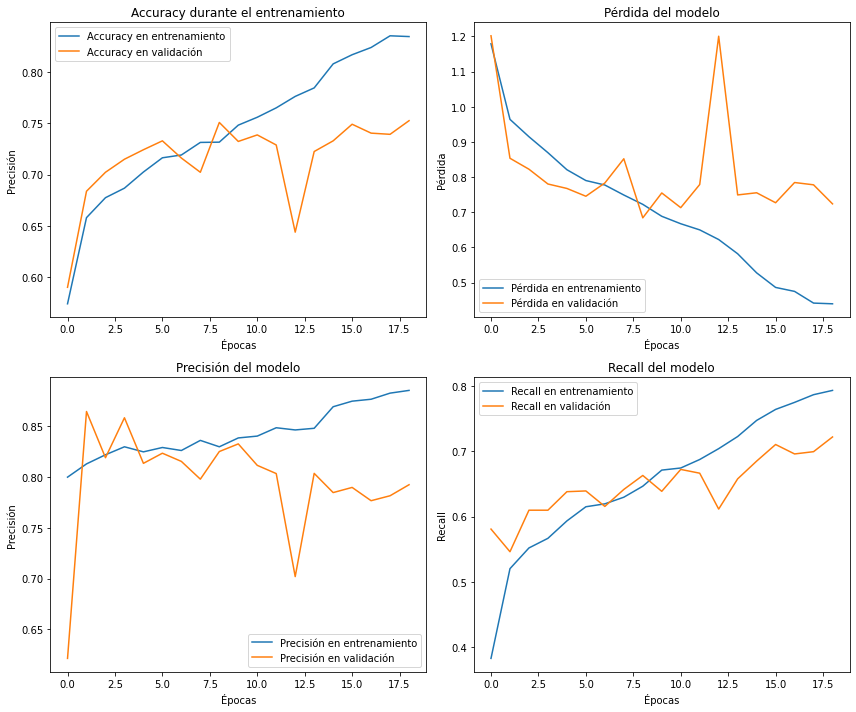

In [170]:
import matplotlib.pyplot as plt

# Establecer una figura para alojar los gráficos
plt.figure(figsize=(12, 10))  # Ajusta el tamaño según tus preferencias

# Gráfica de accuracy
plt.subplot(2, 2, 1)  # 2 filas, 2 columnas, primer gráfico
plt.plot(history.history['accuracy'], label='Accuracy en entrenamiento')
plt.plot(history.history['val_accuracy'], label='Accuracy en validación')
plt.title('Accuracy durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfica de pérdida
plt.subplot(2, 2, 2)  # 2 filas, 2 columnas, segundo gráfico
plt.plot(history.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en validación')
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Gráfica de precisión
plt.subplot(2, 2, 3)  # 2 filas, 2 columnas, tercer gráfico
plt.plot(history.history['precision'], label='Precisión en entrenamiento')
plt.plot(history.history['val_precision'], label='Precisión en validación')
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfica de recall
plt.subplot(2, 2, 4)  # 2 filas, 2 columnas, cuarto gráfico
plt.plot(history.history['recall'], label='Recall en entrenamiento')
plt.plot(history.history['val_recall'], label='Recall en validación')
plt.title('Recall del modelo')
plt.xlabel('Épocas')
plt.ylabel('Recall')
plt.legend()

# Mostrar los gráficos
plt.tight_layout()  # Ajusta el espacio entre los gráficos
plt.show()

### Evaluación

In [171]:
# Evaluar el rendimiento del modelo en el conjunto de prueba
test_loss, test_acc, test_precision, test_recall, test_auc, test_f1 = model.evaluate(
    test_generator,  # Generador del conjunto de prueba
)

# Imprimir los resultados
print(f'Pérdida en el conjunto de prueba: {test_loss}')
print(f'accuracy en el conjunto de prueba: {test_acc}')
print(f'Precision en el conjunto de prueba: {test_precision}')
print(f'Recall en el conjunto de prueba: {test_recall}')
print(f'AUC en el conjunto de prueba: {test_auc}')
print(f'F1-Score en el conjunto de prueba: {test_f1}')

55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 216ms/step - accuracy: 0.5474 - auc: 0.8709 - f1_score: 0.8709 - loss: 1.1082 - precision: 0.6225 - recall: 0.4546
Pérdida en el conjunto de prueba: 0.7293526530265808
accuracy en el conjunto de prueba: 0.7332563400268555
Precision en el conjunto de prueba: 0.8291276097297668
Recall en el conjunto de prueba: 0.6639722585678101
AUC en el conjunto de prueba: 0.9466426372528076
F1-Score en el conjunto de prueba: 0.9466426372528076


55/55 ━━━━━━━━━━━━━━━━━━━━ 13s 242ms/step


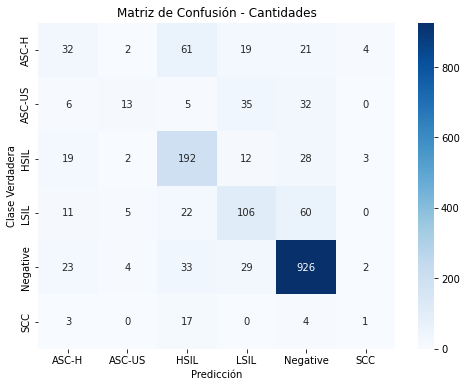

In [175]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Realizar predicciones en el conjunto de prueba
test_steps = int(np.ceil(test_generator.samples / test_generator.batch_size))
predictions = model.predict(test_generator, steps=test_steps)
predicted_classes = np.argmax(predictions, axis=1)

# Obtener las etiquetas verdaderas
true_classes = test_generator.classes

# Obtener las clases
class_labels = list(test_generator.class_indices.keys())

# Crear la matriz de confusión
cm = confusion_matrix(true_classes, predicted_classes)

# Crear la matriz de confusión normalizada (probabilidades)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Función para graficar la matriz de confusión
def plot_confusion_matrix(cm, class_labels, title='Matriz de Confusión', cmap='Blues', fmt='d'):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap=cmap, xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicción')
    plt.ylabel('Clase Verdadera')
    plt.title(title)
    plt.show()

# Graficar la matriz de confusión con cantidades
plot_confusion_matrix(cm, class_labels, title='Matriz de Confusión - Cantidades')

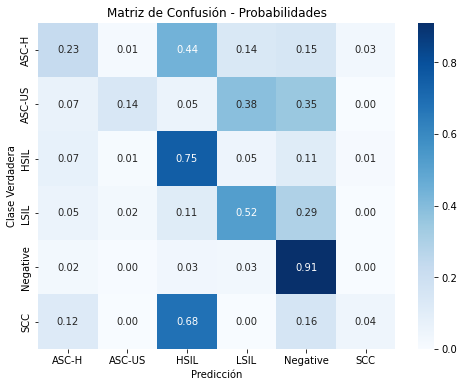

In [174]:
# Graficar la matriz de confusión con probabilidades
plot_confusion_matrix(cm_normalized, class_labels, title='Matriz de Confusión - Probabilidades', fmt='.2f')

In [176]:
# Reporte de clasificación
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

              precision    recall  f1-score   support

       ASC-H       0.34      0.23      0.27       139
      ASC-US       0.50      0.14      0.22        91
        HSIL       0.58      0.75      0.66       256
        LSIL       0.53      0.52      0.52       204
    Negative       0.86      0.91      0.89      1017
         SCC       0.10      0.04      0.06        25

    accuracy                           0.73      1732
   macro avg       0.49      0.43      0.44      1732
weighted avg       0.71      0.73      0.71      1732



55/55 ━━━━━━━━━━━━━━━━━━━━ 13s 227ms/step


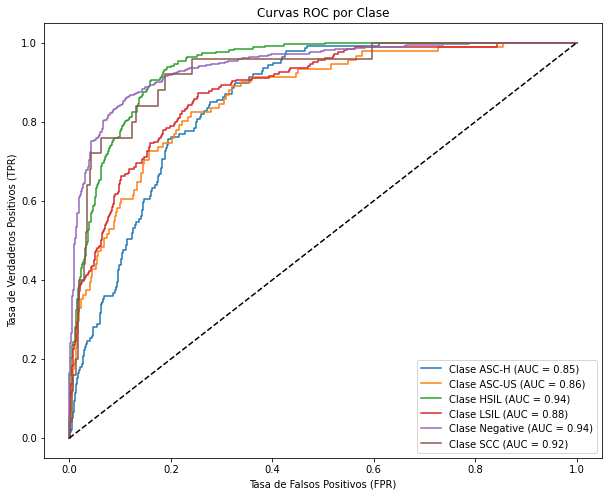

AUC Promedio: 0.90
AUC Promedio Ponderado: 0.92


In [173]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

# Obtener las probabilidades predichas
y_pred_proba = model.predict(test_generator)

# Obtener las etiquetas verdaderas y nombres de las clases
y_true = test_generator.classes  # Etiquetas verdaderas
class_names = list(test_generator.class_indices.keys())  # Nombres de las clases

# Convertir y_true a formato binario por clase
n_classes = len(class_names)
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))


roc_auc = dict()

# Generar curvas ROC para cada clase
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Clase {class_names[i]} (AUC = {auc(fpr, tpr):.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Línea de referencia
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC por Clase')
plt.legend(loc='lower right')
plt.show()

# Calcular y mostrar el AUC promedio
auc_promedio = np.mean(list(roc_auc.values()))
print(f'AUC Promedio: {auc_promedio:.2f}')

# Calcular y mostrar el AUC promedio ponderado
auc_promedio_pond = roc_auc_score(y_true_bin, y_pred_proba, average='weighted', multi_class='ovr')
print(f'AUC Promedio Ponderado: {auc_promedio_pond:.2f}')

## Modelo MobileNetV2

In [177]:
# Cargar el modelo base MobileNetV2 preentrenado
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model.trainable = True

# Descongelar las capas necesarias para ajuste fino
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Construir el modelo
inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base_model(inputs, training=True)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs, outputs)

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy',
                    tf.keras.metrics.Precision(name='precision'), 
                    tf.keras.metrics.Recall(name='recall'), 
                    tf.keras.metrics.AUC(name='auc'),
                    tf.keras.metrics.AUC(name='f1_score')])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)

# Entrenamiento del modelo
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr]
)

/var/folders/kl/780b8_9s0y35m4d8w8w07wfh0000gn/T/ipykernel_98935/770786427.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))


Epoch 1/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 25s 79ms/step - accuracy: 0.5512 - auc: 0.8302 - f1_score: 0.8302 - loss: 1.2928 - precision: 0.6815 - recall: 0.4154 - val_accuracy: 0.6110 - val_auc: 0.8313 - val_f1_score: 0.8313 - val_loss: 2.5029 - val_precision: 0.6128 - val_recall: 0.6092 - learning_rate: 1.0000e-04
Epoch 2/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 20s 77ms/step - accuracy: 0.7086 - auc: 0.9338 - f1_score: 0.9338 - loss: 0.8087 - precision: 0.8233 - recall: 0.5972 - val_accuracy: 0.6682 - val_auc: 0.8887 - val_f1_score: 0.8887 - val_loss: 1.5626 - val_precision: 0.6843 - val_recall: 0.6439 - learning_rate: 1.0000e-04
Epoch 3/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 20s 76ms/step - accuracy: 0.7399 - auc: 0.9486 - f1_score: 0.9486 - loss: 0.7124 - precision: 0.8399 - recall: 0.6454 - val_accuracy: 0.7491 - val_auc: 0.9361 - val_f1_score: 0.9361 - val_loss: 0.8945 - val_precision: 0.7854 - val_recall: 0.7150 - learning_rate: 1.0000e-04
Epoch 4/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 20s 79ms/step - ac

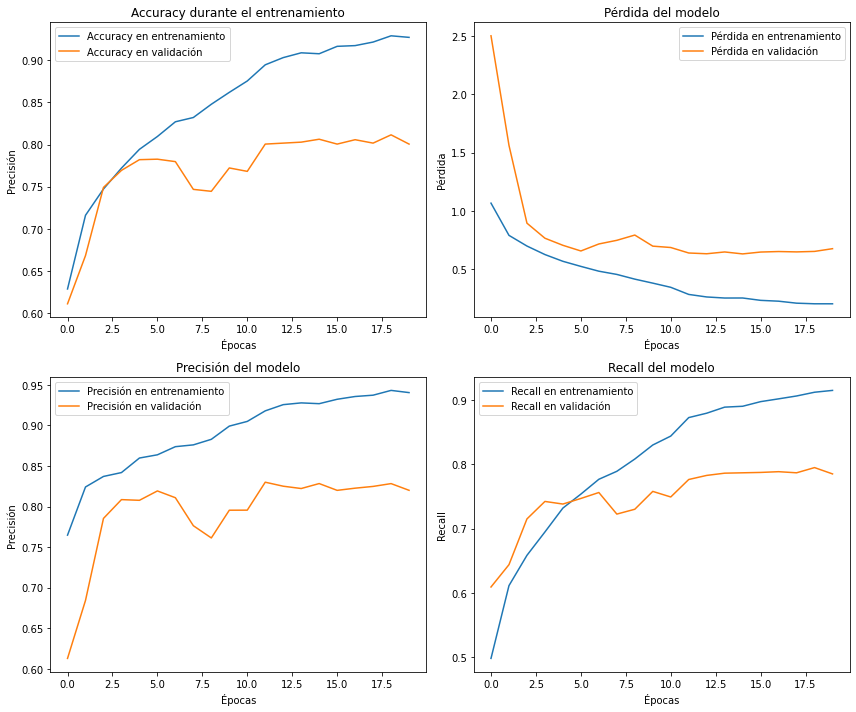

In [178]:
import matplotlib.pyplot as plt

# Establecer una figura para alojar los gráficos
plt.figure(figsize=(12, 10))  # Ajusta el tamaño según tus preferencias

# Gráfica de accuracy
plt.subplot(2, 2, 1)  # 2 filas, 2 columnas, primer gráfico
plt.plot(history.history['accuracy'], label='Accuracy en entrenamiento')
plt.plot(history.history['val_accuracy'], label='Accuracy en validación')
plt.title('Accuracy durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfica de pérdida
plt.subplot(2, 2, 2)  # 2 filas, 2 columnas, segundo gráfico
plt.plot(history.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en validación')
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Gráfica de precisión
plt.subplot(2, 2, 3)  # 2 filas, 2 columnas, tercer gráfico
plt.plot(history.history['precision'], label='Precisión en entrenamiento')
plt.plot(history.history['val_precision'], label='Precisión en validación')
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfica de recall
plt.subplot(2, 2, 4)  # 2 filas, 2 columnas, cuarto gráfico
plt.plot(history.history['recall'], label='Recall en entrenamiento')
plt.plot(history.history['val_recall'], label='Recall en validación')
plt.title('Recall del modelo')
plt.xlabel('Épocas')
plt.ylabel('Recall')
plt.legend()

# Mostrar los gráficos
plt.tight_layout()  # Ajusta el espacio entre los gráficos
plt.show()

### Evaluación

In [179]:
# Evaluar el rendimiento del modelo en el conjunto de prueba
test_loss, test_acc, test_precision, test_recall, test_auc, test_f1 = model.evaluate(
    test_generator,  # Generador del conjunto de prueba
)

# Imprimir los resultados
print(f'Pérdida en el conjunto de prueba: {test_loss}')
print(f'accuracy en el conjunto de prueba: {test_acc}')
print(f'Precision en el conjunto de prueba: {test_precision}')
print(f'Recall en el conjunto de prueba: {test_recall}')
print(f'AUC en el conjunto de prueba: {test_auc}')
print(f'F1-Score en el conjunto de prueba: {test_f1}')

55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.6760 - auc: 0.9219 - f1_score: 0.9219 - loss: 0.9933 - precision: 0.7103 - recall: 0.6523
Pérdida en el conjunto de prueba: 0.6191080808639526
accuracy en el conjunto de prueba: 0.795034646987915
Precision en el conjunto de prueba: 0.8236374855041504
Recall en el conjunto de prueba: 0.7765588760375977
AUC en el conjunto de prueba: 0.9641438126564026
F1-Score en el conjunto de prueba: 0.9641438126564026


55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step


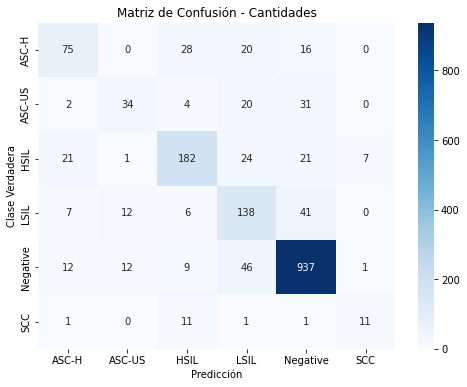

In [180]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Realizar predicciones en el conjunto de prueba
test_steps = int(np.ceil(test_generator.samples / test_generator.batch_size))
predictions = model.predict(test_generator, steps=test_steps)
predicted_classes = np.argmax(predictions, axis=1)

# Obtener las etiquetas verdaderas
true_classes = test_generator.classes

# Obtener las clases
class_labels = list(test_generator.class_indices.keys())

# Crear la matriz de confusión
cm = confusion_matrix(true_classes, predicted_classes)

# Crear la matriz de confusión normalizada (probabilidades)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Función para graficar la matriz de confusión
def plot_confusion_matrix(cm, class_labels, title='Matriz de Confusión', cmap='Blues', fmt='d'):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap=cmap, xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicción')
    plt.ylabel('Clase Verdadera')
    plt.title(title)
    plt.show()

# Graficar la matriz de confusión con cantidades
plot_confusion_matrix(cm, class_labels, title='Matriz de Confusión - Cantidades')

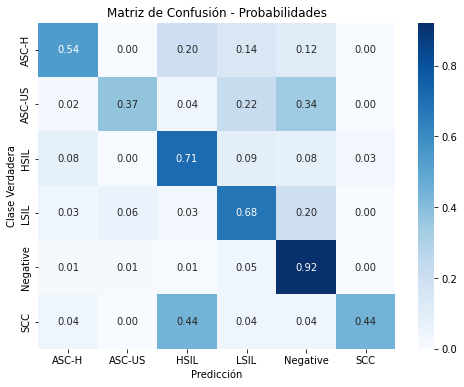

In [181]:
# Graficar la matriz de confusión con probabilidades
plot_confusion_matrix(cm_normalized, class_labels, title='Matriz de Confusión - Probabilidades', fmt='.2f')

In [182]:
# Reporte de clasificación
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

              precision    recall  f1-score   support

       ASC-H       0.64      0.54      0.58       139
      ASC-US       0.58      0.37      0.45        91
        HSIL       0.76      0.71      0.73       256
        LSIL       0.55      0.68      0.61       204
    Negative       0.89      0.92      0.91      1017
         SCC       0.58      0.44      0.50        25

    accuracy                           0.80      1732
   macro avg       0.67      0.61      0.63      1732
weighted avg       0.79      0.80      0.79      1732



55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step


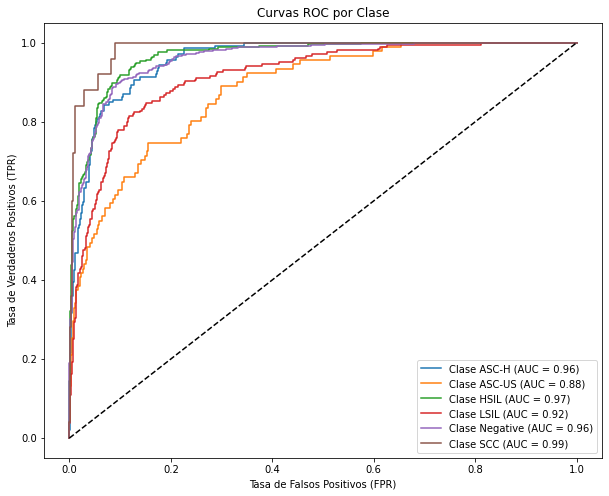

AUC Promedio: 0.94
AUC Promedio Ponderado: 0.95


In [183]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

# Obtener las probabilidades predichas
y_pred_proba = model.predict(test_generator)

# Obtener las etiquetas verdaderas y nombres de las clases
y_true = test_generator.classes  # Etiquetas verdaderas
class_names = list(test_generator.class_indices.keys())  # Nombres de las clases

# Convertir y_true a formato binario por clase
n_classes = len(class_names)
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

roc_auc = dict()

# Generar curvas ROC para cada clase
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Clase {class_names[i]} (AUC = {auc(fpr, tpr):.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Línea de referencia
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC por Clase')
plt.legend(loc='lower right')
plt.show()

# Calcular y mostrar el AUC promedio
auc_promedio = np.mean(list(roc_auc.values()))
print(f'AUC Promedio: {auc_promedio:.2f}')

# Calcular y mostrar el AUC promedio ponderado
auc_promedio_pond = roc_auc_score(y_true_bin, y_pred_proba, average='weighted', multi_class='ovr')
print(f'AUC Promedio Ponderado: {auc_promedio_pond:.2f}')

## Modelo MobileNetV3

In [184]:
# Cargar el modelo base MobileNetV2 preentrenado
base_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model.trainable = True

# Descongelar las capas necesarias para ajuste fino
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Construir el modelo
inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base_model(inputs, training=True)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs, outputs)

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy',
                    tf.keras.metrics.Precision(name='precision'), 
                    tf.keras.metrics.Recall(name='recall'), 
                    tf.keras.metrics.AUC(name='auc'),
                    tf.keras.metrics.AUC(name='f1_score')])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)

# Entrenamiento del modelo
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr]
)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/applications/mobilenet_v3.py:517: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


Epoch 1/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 27s 84ms/step - accuracy: 0.5981 - auc: 0.8650 - f1_score: 0.8650 - loss: 1.1342 - precision: 0.7479 - recall: 0.4572 - val_accuracy: 0.1474 - val_auc: 0.6380 - val_f1_score: 0.6380 - val_loss: 2.1461 - val_precision: 0.1476 - val_recall: 0.1474 - learning_rate: 1.0000e-04
Epoch 2/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 22s 85ms/step - accuracy: 0.6794 - auc: 0.9154 - f1_score: 0.9154 - loss: 0.9114 - precision: 0.8046 - recall: 0.5538 - val_accuracy: 0.1474 - val_auc: 0.6436 - val_f1_score: 0.6436 - val_loss: 1.8861 - val_precision: 0.1407 - val_recall: 0.1370 - learning_rate: 1.0000e-04
Epoch 3/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 22s 87ms/step - accuracy: 0.6931 - auc: 0.9225 - f1_score: 0.9225 - loss: 0.8737 - precision: 0.8063 - recall: 0.5731 - val_accuracy: 0.1792 - val_auc: 0.7461 - val_f1_score: 0.7461 - val_loss: 1.4574 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 4/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 22s 85ms/s

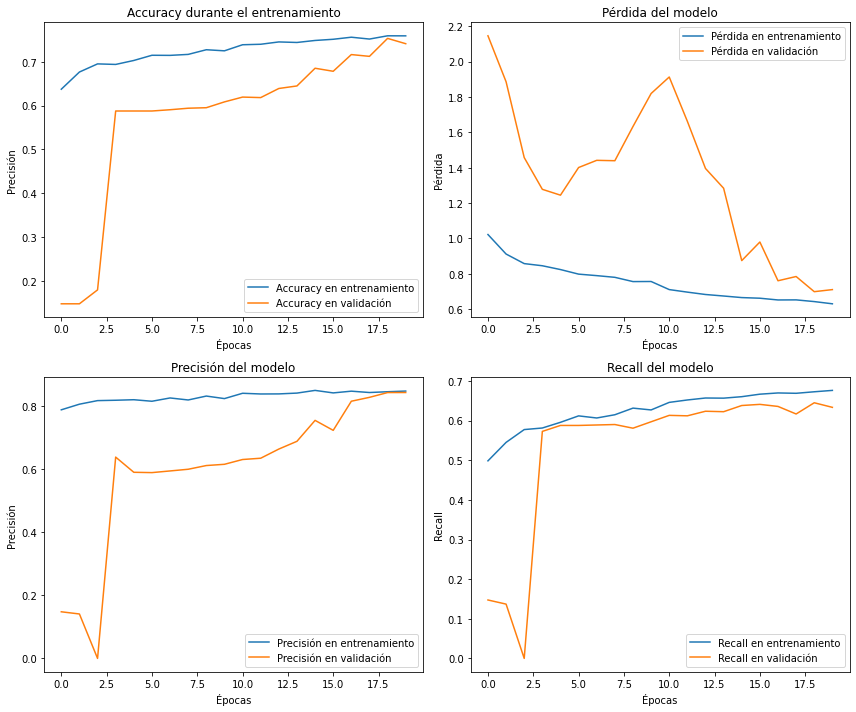

In [185]:
import matplotlib.pyplot as plt

# Establecer una figura para alojar los gráficos
plt.figure(figsize=(12, 10))  # Ajusta el tamaño según tus preferencias

# Gráfica de accuracy
plt.subplot(2, 2, 1)  # 2 filas, 2 columnas, primer gráfico
plt.plot(history.history['accuracy'], label='Accuracy en entrenamiento')
plt.plot(history.history['val_accuracy'], label='Accuracy en validación')
plt.title('Accuracy durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfica de pérdida
plt.subplot(2, 2, 2)  # 2 filas, 2 columnas, segundo gráfico
plt.plot(history.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en validación')
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Gráfica de precisión
plt.subplot(2, 2, 3)  # 2 filas, 2 columnas, tercer gráfico
plt.plot(history.history['precision'], label='Precisión en entrenamiento')
plt.plot(history.history['val_precision'], label='Precisión en validación')
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfica de recall
plt.subplot(2, 2, 4)  # 2 filas, 2 columnas, cuarto gráfico
plt.plot(history.history['recall'], label='Recall en entrenamiento')
plt.plot(history.history['val_recall'], label='Recall en validación')
plt.title('Recall del modelo')
plt.xlabel('Épocas')
plt.ylabel('Recall')
plt.legend()

# Mostrar los gráficos
plt.tight_layout()  # Ajusta el espacio entre los gráficos
plt.show()

### Evaluación

In [186]:
import numpy as np
from sklearn.metrics import confusion_matrix, recall_score, precision_score

# Evaluar el rendimiento del modelo en el conjunto de prueba
test_loss, test_acc, test_precision, test_recall, test_auc, test_f1 = model.evaluate(
    test_generator,  # Generador del conjunto de prueba
)

# Imprimir los resultados
print(f'Pérdida en el conjunto de prueba: {test_loss}')
print(f'accuracy en el conjunto de prueba: {test_acc}')
print(f'Precision en el conjunto de prueba: {test_precision}')
print(f'Recall en el conjunto de prueba: {test_recall}')
print(f'AUC en el conjunto de prueba: {test_auc}')
print(f'F1-Score en el conjunto de prueba: {test_f1}')


55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.5274 - auc: 0.8698 - f1_score: 0.8698 - loss: 1.0835 - precision: 0.6201 - recall: 0.4191
Pérdida en el conjunto de prueba: 0.7101051211357117
accuracy en el conjunto de prueba: 0.7338337302207947
Precision en el conjunto de prueba: 0.8433459997177124
Recall en el conjunto de prueba: 0.6403002142906189
AUC en el conjunto de prueba: 0.9493201971054077
F1-Score en el conjunto de prueba: 0.9493201971054077


55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step


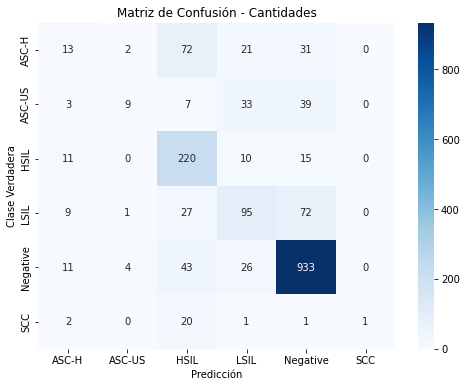

In [187]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Realizar predicciones en el conjunto de prueba
test_steps = int(np.ceil(test_generator.samples / test_generator.batch_size))
predictions = model.predict(test_generator, steps=test_steps)
predicted_classes = np.argmax(predictions, axis=1)

# Obtener las etiquetas verdaderas
true_classes = test_generator.classes

# Obtener las clases
class_labels = list(test_generator.class_indices.keys())

# Crear la matriz de confusión
cm = confusion_matrix(true_classes, predicted_classes)

# Crear la matriz de confusión normalizada (probabilidades)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Función para graficar la matriz de confusión
def plot_confusion_matrix(cm, class_labels, title='Matriz de Confusión', cmap='Blues', fmt='d'):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap=cmap, xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicción')
    plt.ylabel('Clase Verdadera')
    plt.title(title)
    plt.show()

# Graficar la matriz de confusión con cantidades
plot_confusion_matrix(cm, class_labels, title='Matriz de Confusión - Cantidades')

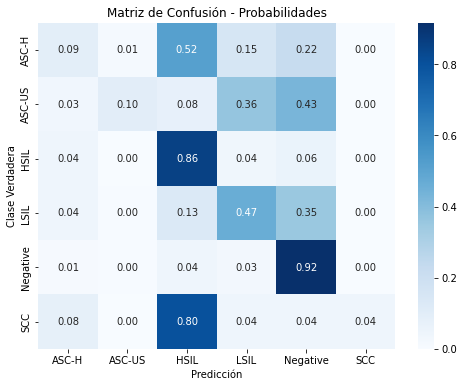

In [188]:
# Graficar la matriz de confusión con probabilidades
plot_confusion_matrix(cm_normalized, class_labels, title='Matriz de Confusión - Probabilidades', fmt='.2f')

In [189]:
# Reporte de clasificación
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

              precision    recall  f1-score   support

       ASC-H       0.27      0.09      0.14       139
      ASC-US       0.56      0.10      0.17        91
        HSIL       0.57      0.86      0.68       256
        LSIL       0.51      0.47      0.49       204
    Negative       0.86      0.92      0.89      1017
         SCC       1.00      0.04      0.08        25

    accuracy                           0.73      1732
   macro avg       0.63      0.41      0.41      1732
weighted avg       0.71      0.73      0.70      1732



55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step


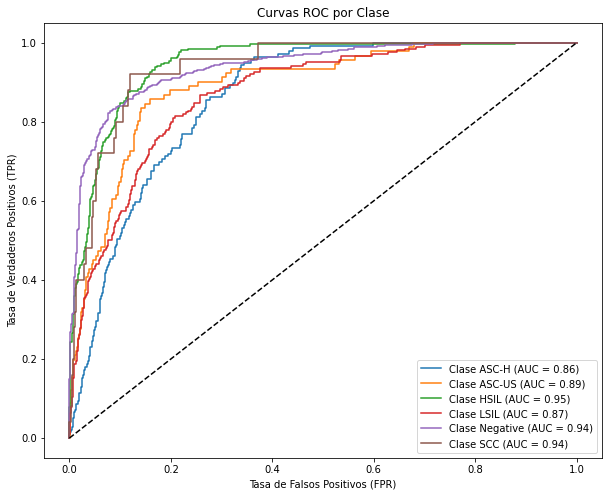

AUC Promedio: 0.91
AUC Promedio Ponderado: 0.92


In [190]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

# Obtener las probabilidades predichas
y_pred_proba = model.predict(test_generator)

# Obtener las etiquetas verdaderas y nombres de las clases
y_true = test_generator.classes  # Etiquetas verdaderas
class_names = list(test_generator.class_indices.keys())  # Nombres de las clases

# Convertir y_true a formato binario por clase
n_classes = len(class_names)
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

roc_auc = dict()

# Generar curvas ROC para cada clase
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Clase {class_names[i]} (AUC = {auc(fpr, tpr):.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Línea de referencia
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC por Clase')
plt.legend(loc='lower right')
plt.show()

# Calcular y mostrar el AUC promedio
auc_promedio = np.mean(list(roc_auc.values()))
print(f'AUC Promedio: {auc_promedio:.2f}')

# Calcular y mostrar el AUC promedio ponderado
auc_promedio_pond = roc_auc_score(y_true_bin, y_pred_proba, average='weighted', multi_class='ovr')
print(f'AUC Promedio Ponderado: {auc_promedio_pond:.2f}')

## Modelo InceptionV3

In [191]:
# Importar y Definir el Modelo InceptionV3
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model.trainable = True

# Descongelar las capas necesarias para ajuste fino
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Construir el modelo
inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base_model(inputs, training=True)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs, outputs)

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy',
                    tf.keras.metrics.Precision(name='precision'), 
                    tf.keras.metrics.Recall(name='recall'), 
                    tf.keras.metrics.AUC(name='auc'),
                    tf.keras.metrics.AUC(name='f1_score')])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)

# Entrenamiento del modelo
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 65s 208ms/step - accuracy: 0.5836 - auc: 0.8347 - f1_score: 0.8347 - loss: 1.2408 - precision: 0.7195 - recall: 0.3802 - val_accuracy: 0.6908 - val_auc: 0.9244 - val_f1_score: 0.9244 - val_loss: 0.8738 - val_precision: 0.8327 - val_recall: 0.5983 - learning_rate: 1.0000e-04
Epoch 2/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 54s 213ms/step - accuracy: 0.7033 - auc: 0.9266 - f1_score: 0.9266 - loss: 0.8549 - precision: 0.8371 - recall: 0.5804 - val_accuracy: 0.7376 - val_auc: 0.9471 - val_f1_score: 0.9471 - val_loss: 0.7279 - val_precision: 0.8440 - val_recall: 0.6318 - learning_rate: 1.0000e-04
Epoch 3/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 57s 224ms/step - accuracy: 0.7404 - auc: 0.9471 - f1_score: 0.9471 - loss: 0.7272 - precision: 0.8469 - recall: 0.6392 - val_accuracy: 0.7561 - val_auc: 0.9549 - val_f1_score: 0.9549 - val_loss: 0.6713 - val_precision: 0.8520 - val_recall: 0.6723 - learning_rate: 1.0000e-04
Epoch 4/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 56s 221ms/step 

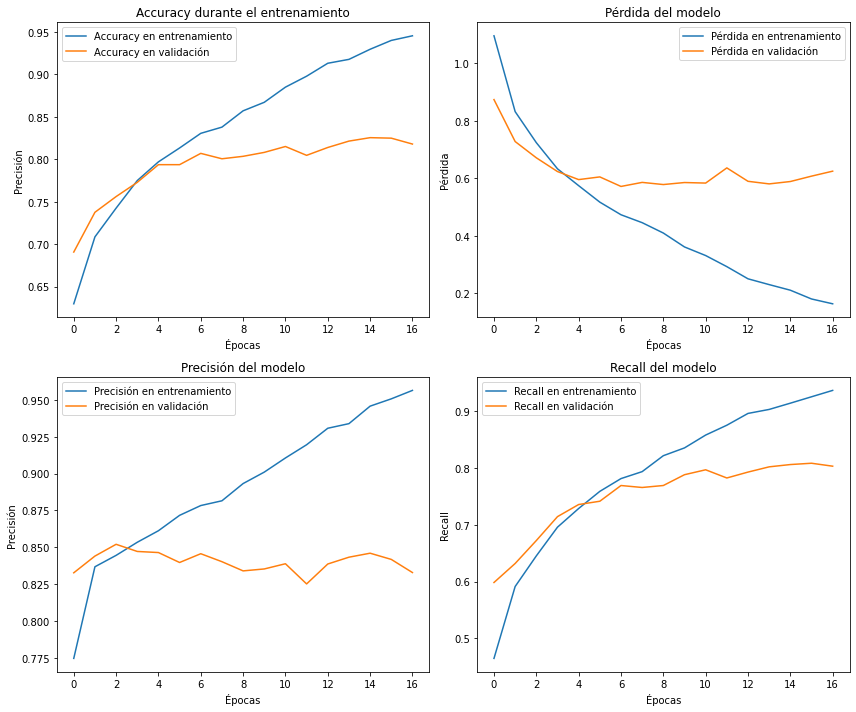

In [192]:
import matplotlib.pyplot as plt

# Establecer una figura para alojar los gráficos
plt.figure(figsize=(12, 10))  # Ajusta el tamaño según tus preferencias

# Gráfica de accuracy
plt.subplot(2, 2, 1)  # 2 filas, 2 columnas, primer gráfico
plt.plot(history.history['accuracy'], label='Accuracy en entrenamiento')
plt.plot(history.history['val_accuracy'], label='Accuracy en validación')
plt.title('Accuracy durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfica de pérdida
plt.subplot(2, 2, 2)  # 2 filas, 2 columnas, segundo gráfico
plt.plot(history.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en validación')
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Gráfica de precisión
plt.subplot(2, 2, 3)  # 2 filas, 2 columnas, tercer gráfico
plt.plot(history.history['precision'], label='Precisión en entrenamiento')
plt.plot(history.history['val_precision'], label='Precisión en validación')
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfica de recall
plt.subplot(2, 2, 4)  # 2 filas, 2 columnas, cuarto gráfico
plt.plot(history.history['recall'], label='Recall en entrenamiento')
plt.plot(history.history['val_recall'], label='Recall en validación')
plt.title('Recall del modelo')
plt.xlabel('Épocas')
plt.ylabel('Recall')
plt.legend()

# Mostrar los gráficos
plt.tight_layout()  # Ajusta el espacio entre los gráficos
plt.show()

### Evaluación

In [193]:
import numpy as np
from sklearn.metrics import confusion_matrix, recall_score, precision_score

# Evaluar el rendimiento del modelo en el conjunto de prueba
test_loss, test_acc, test_precision, test_recall, test_auc, test_f1 = model.evaluate(
    test_generator,  # Generador del conjunto de prueba
)

# Imprimir los resultados
print(f'Pérdida en el conjunto de prueba: {test_loss}')
print(f'accuracy en el conjunto de prueba: {test_acc}')
print(f'Precision en el conjunto de prueba: {test_precision}')
print(f'Recall en el conjunto de prueba: {test_recall}')
print(f'AUC en el conjunto de prueba: {test_auc}')
print(f'F1-Score en el conjunto de prueba: {test_f1}')

55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 0.6756 - auc: 0.9168 - f1_score: 0.9168 - loss: 0.9214 - precision: 0.7102 - recall: 0.5976
Pérdida en el conjunto de prueba: 0.575361967086792
accuracy en el conjunto de prueba: 0.8100461959838867
Precision en el conjunto de prueba: 0.8480104207992554
Recall en el conjunto de prueba: 0.7505773901939392
AUC en el conjunto de prueba: 0.9657548069953918
F1-Score en el conjunto de prueba: 0.9657548069953918


55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step


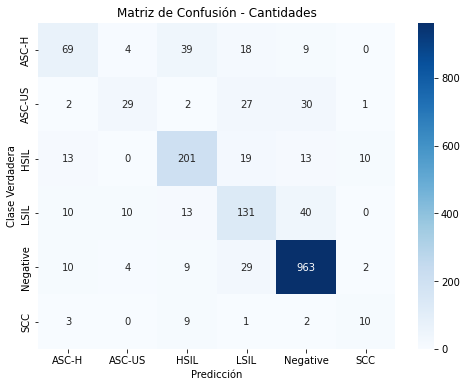

In [194]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Realizar predicciones en el conjunto de prueba
test_steps = int(np.ceil(test_generator.samples / test_generator.batch_size))
predictions = model.predict(test_generator, steps=test_steps)
predicted_classes = np.argmax(predictions, axis=1)

# Obtener las etiquetas verdaderas
true_classes = test_generator.classes

# Obtener las clases
class_labels = list(test_generator.class_indices.keys())

# Crear la matriz de confusión
cm = confusion_matrix(true_classes, predicted_classes)

# Crear la matriz de confusión normalizada (probabilidades)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Función para graficar la matriz de confusión
def plot_confusion_matrix(cm, class_labels, title='Matriz de Confusión', cmap='Blues', fmt='d'):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap=cmap, xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicción')
    plt.ylabel('Clase Verdadera')
    plt.title(title)
    plt.show()

# Graficar la matriz de confusión con cantidades
plot_confusion_matrix(cm, class_labels, title='Matriz de Confusión - Cantidades')

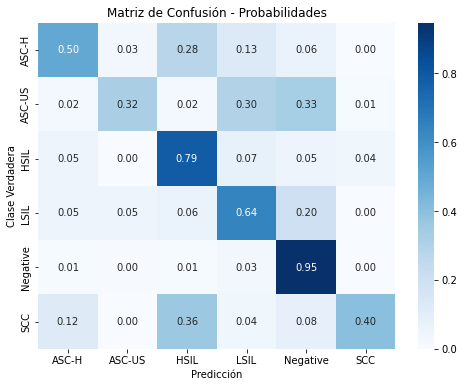

In [195]:
# Graficar la matriz de confusión con probabilidades
plot_confusion_matrix(cm_normalized, class_labels, title='Matriz de Confusión - Probabilidades', fmt='.2f')

In [196]:
# Reporte de clasificación
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

              precision    recall  f1-score   support

       ASC-H       0.64      0.50      0.56       139
      ASC-US       0.62      0.32      0.42        91
        HSIL       0.74      0.79      0.76       256
        LSIL       0.58      0.64      0.61       204
    Negative       0.91      0.95      0.93      1017
         SCC       0.43      0.40      0.42        25

    accuracy                           0.81      1732
   macro avg       0.65      0.60      0.62      1732
weighted avg       0.80      0.81      0.80      1732



55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step


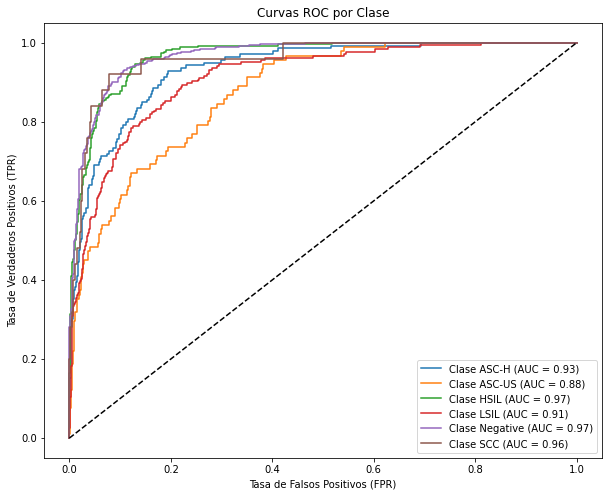

AUC Promedio: 0.94
AUC Promedio Ponderado: 0.95


In [197]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

# Obtener las probabilidades predichas
y_pred_proba = model.predict(test_generator)

# Obtener las etiquetas verdaderas y nombres de las clases
y_true = test_generator.classes  # Etiquetas verdaderas
class_names = list(test_generator.class_indices.keys())  # Nombres de las clases

# Convertir y_true a formato binario por clase
n_classes = len(class_names)
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

roc_auc = dict()

# Generar curvas ROC para cada clase
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Clase {class_names[i]} (AUC = {auc(fpr, tpr):.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Línea de referencia
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC por Clase')
plt.legend(loc='lower right')
plt.show()

# Calcular y mostrar el AUC promedio
auc_promedio = np.mean(list(roc_auc.values()))
print(f'AUC Promedio: {auc_promedio:.2f}')

# Calcular y mostrar el AUC promedio ponderado
auc_promedio_pond = roc_auc_score(y_true_bin, y_pred_proba, average='weighted', multi_class='ovr')
print(f'AUC Promedio Ponderado: {auc_promedio_pond:.2f}')

## Modelo Xception

In [198]:
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Configuración de parámetros
IMG_HEIGHT, IMG_WIDTH = 90, 90
BATCH_SIZE = 32
NUM_CLASSES = len(train_generator.class_indices)

# Pesos de clase para manejar el desbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

# Cargar el modelo base Xception preentrenado en ImageNet
base_model = Xception(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model.trainable = True  # Habilitamos el fine-tuning completo

# Congelar las primeras capas para evitar sobreajuste rápido
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Definir el modelo
inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base_model(inputs, training=True)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(NUM_CLASSES, activation='softmax')(x)
model = Model(inputs, outputs)

# Compilar el modelo
model.compile(
    optimizer=Adam(learning_rate=0.0001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy',
             tf.keras.metrics.Precision(name='precision'), 
             tf.keras.metrics.Recall(name='recall'), 
             tf.keras.metrics.AUC(name='auc')]
)

# Callbacks
early_stopping = EarlyStopping(monitor='val_recall', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)

# Entrenar el modelo
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    class_weight=class_weights,  # Aplicar los pesos de clase
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 113s 433ms/step - accuracy: 0.3626 - auc: 0.6884 - loss: 1.6818 - precision: 0.6782 - recall: 0.0772 - val_accuracy: 0.5844 - val_auc: 0.8666 - val_loss: 1.1554 - val_precision: 0.7176 - val_recall: 0.4451 - learning_rate: 1.0000e-04
Epoch 2/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 109s 429ms/step - accuracy: 0.6170 - auc: 0.8815 - loss: 1.0713 - precision: 0.7636 - recall: 0.4103 - val_accuracy: 0.6740 - val_auc: 0.9094 - val_loss: 0.9491 - val_precision: 0.7643 - val_recall: 0.5491 - learning_rate: 1.0000e-04
Epoch 3/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 106s 416ms/step - accuracy: 0.6760 - auc: 0.9224 - loss: 0.8863 - precision: 0.7965 - recall: 0.5512 - val_accuracy: 0.6491 - val_auc: 0.9113 - val_loss: 0.9450 - val_precision: 0.7224 - val_recall: 0.5491 - learning_rate: 1.0000e-04
Epoch 4/20
253/253 ━━━━━━━━━━━━━━━━━━━━ 109s 429ms/step - accuracy: 0.7118 - auc: 0.9361 - loss: 0.7473 - precision: 0.8012 - recall: 0.6115 - val_accuracy: 0.7040 - val_auc: 0.9

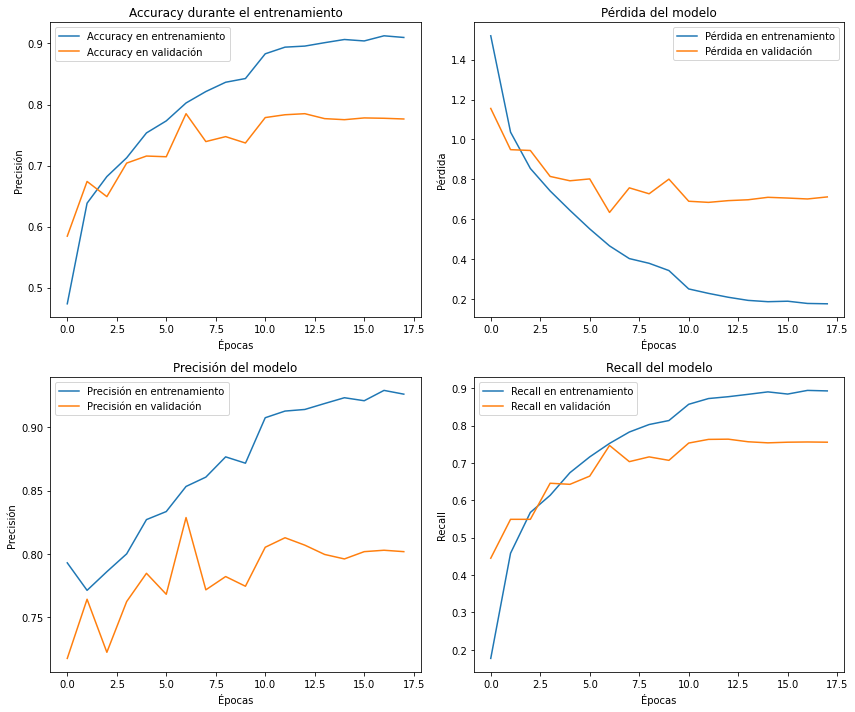

In [199]:
import matplotlib.pyplot as plt

# Establecer una figura para alojar los gráficos
plt.figure(figsize=(12, 10))  # Ajusta el tamaño según tus preferencias

# Gráfica de accuracy
plt.subplot(2, 2, 1)  # 2 filas, 2 columnas, primer gráfico
plt.plot(history.history['accuracy'], label='Accuracy en entrenamiento')
plt.plot(history.history['val_accuracy'], label='Accuracy en validación')
plt.title('Accuracy durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfica de pérdida
plt.subplot(2, 2, 2)  # 2 filas, 2 columnas, segundo gráfico
plt.plot(history.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en validación')
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Gráfica de precisión
plt.subplot(2, 2, 3)  # 2 filas, 2 columnas, tercer gráfico
plt.plot(history.history['precision'], label='Precisión en entrenamiento')
plt.plot(history.history['val_precision'], label='Precisión en validación')
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfica de recall
plt.subplot(2, 2, 4)  # 2 filas, 2 columnas, cuarto gráfico
plt.plot(history.history['recall'], label='Recall en entrenamiento')
plt.plot(history.history['val_recall'], label='Recall en validación')
plt.title('Recall del modelo')
plt.xlabel('Épocas')
plt.ylabel('Recall')
plt.legend()

# Mostrar los gráficos
plt.tight_layout()  # Ajusta el espacio entre los gráficos
plt.show()

### Evaluación

In [200]:
# Evaluar el rendimiento del modelo en el conjunto de prueba
test_loss, test_acc, test_precision, test_recall, test_auc = model.evaluate(
    test_generator,  # Generador del conjunto de prueba
)

# Imprimir los resultados
print(f'Pérdida en el conjunto de prueba: {test_loss}')
print(f'accuracy en el conjunto de prueba: {test_acc}')
print(f'Precision en el conjunto de prueba: {test_precision}')
print(f'Recall en el conjunto de prueba: {test_recall}')
print(f'AUC en el conjunto de prueba: {test_auc}')

55/55 ━━━━━━━━━━━━━━━━━━━━ 11s 208ms/step - accuracy: 0.7058 - auc: 0.9337 - loss: 0.9423 - precision: 0.7216 - recall: 0.6872
Pérdida en el conjunto de prueba: 0.6733723878860474
accuracy en el conjunto de prueba: 0.781177818775177
Precision en el conjunto de prueba: 0.7986618280410767
Recall en el conjunto de prueba: 0.758083164691925
AUC en el conjunto de prueba: 0.9598623514175415


55/55 ━━━━━━━━━━━━━━━━━━━━ 13s 229ms/step


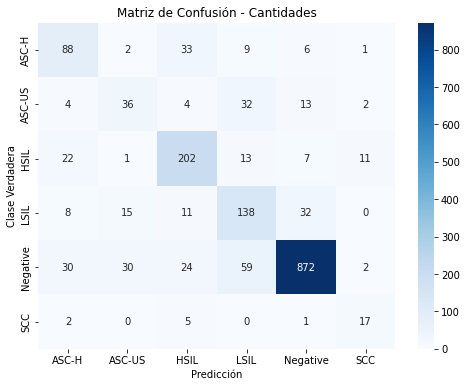

In [201]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Realizar predicciones en el conjunto de prueba
test_steps = int(np.ceil(test_generator.samples / test_generator.batch_size))
predictions = model.predict(test_generator, steps=test_steps)
predicted_classes = np.argmax(predictions, axis=1)

# Obtener las etiquetas verdaderas
true_classes = test_generator.classes

# Obtener las clases
class_labels = list(test_generator.class_indices.keys())

# Crear la matriz de confusión
cm = confusion_matrix(true_classes, predicted_classes)

# Crear la matriz de confusión normalizada (probabilidades)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Función para graficar la matriz de confusión
def plot_confusion_matrix(cm, class_labels, title='Matriz de Confusión', cmap='Blues', fmt='d'):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap=cmap, xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicción')
    plt.ylabel('Clase Verdadera')
    plt.title(title)
    plt.show()

# Graficar la matriz de confusión con cantidades
plot_confusion_matrix(cm, class_labels, title='Matriz de Confusión - Cantidades')

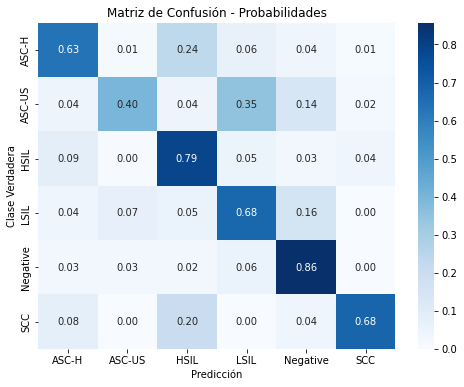

In [202]:
# Graficar la matriz de confusión con probabilidades
plot_confusion_matrix(cm_normalized, class_labels, title='Matriz de Confusión - Probabilidades', fmt='.2f')

In [203]:
# Reporte de clasificación
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

              precision    recall  f1-score   support

       ASC-H       0.57      0.63      0.60       139
      ASC-US       0.43      0.40      0.41        91
        HSIL       0.72      0.79      0.76       256
        LSIL       0.55      0.68      0.61       204
    Negative       0.94      0.86      0.90      1017
         SCC       0.52      0.68      0.59        25

    accuracy                           0.78      1732
   macro avg       0.62      0.67      0.64      1732
weighted avg       0.80      0.78      0.79      1732



55/55 ━━━━━━━━━━━━━━━━━━━━ 11s 207ms/step


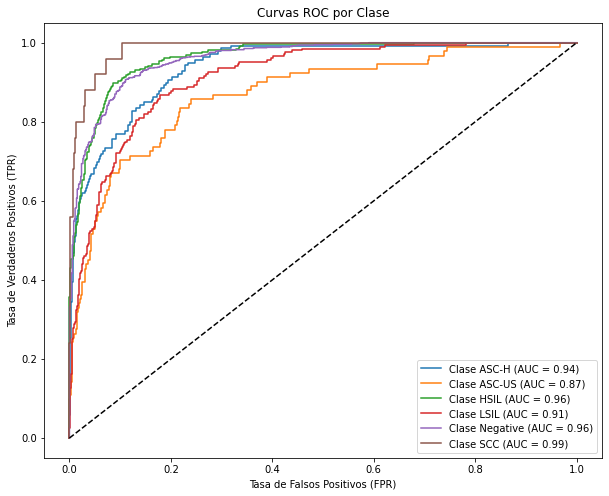

AUC Promedio: 0.94
AUC Promedio Ponderado: 0.95


In [204]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

# Obtener las probabilidades predichas
y_pred_proba = model.predict(test_generator)

# Obtener las etiquetas verdaderas y nombres de las clases
y_true = test_generator.classes  # Etiquetas verdaderas
class_names = list(test_generator.class_indices.keys())  # Nombres de las clases

# Convertir y_true a formato binario por clase
n_classes = len(class_names)
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

roc_auc = dict()

# Generar curvas ROC para cada clase
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Clase {class_names[i]} (AUC = {auc(fpr, tpr):.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Línea de referencia
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC por Clase')
plt.legend(loc='lower right')
plt.show()

# Calcular y mostrar el AUC promedio
auc_promedio = np.mean(list(roc_auc.values()))
print(f'AUC Promedio: {auc_promedio:.2f}')

# Calcular y mostrar el AUC promedio ponderado
auc_promedio_pond = roc_auc_score(y_true_bin, y_pred_proba, average='weighted', multi_class='ovr')
print(f'AUC Promedio Ponderado: {auc_promedio_pond:.2f}')

## Modelo Exception 2.0

In [20]:
# Actualizar las dimensiones de las imágenes
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32

# Configuración del generador de aumentación para entrenamiento
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True
)

# Generador sin aumentación para validación y prueba
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Actualizar el tamaño objetivo en los generadores para que coincida con el modelo
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 8072 images belonging to 6 classes.
Found 1730 images belonging to 6 classes.
Found 1732 images belonging to 6 classes.


In [21]:
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Configuración de parámetros
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32
NUM_CLASSES = len(train_generator.class_indices)

# Pesos de clase para manejar el desbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

# Cargar el modelo base Xception preentrenado en ImageNet
base_model = Xception(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model.trainable = True  # Habilitamos el fine-tuning completo

# Congelar las primeras capas para evitar sobreajuste rápido
fine_tune_at = 75
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Definir el modelo
inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base_model(inputs, training=True)
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.6)(x)
outputs = Dense(NUM_CLASSES, activation='softmax')(x)
model = Model(inputs, outputs)

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy',
                    tf.keras.metrics.Precision(name='precision'), 
                    tf.keras.metrics.Recall(name='recall'), 
                    tf.keras.metrics.AUC(name='auc'),
                    tf.keras.metrics.AUC(name='f1_score')])

# Callbacks
early_stopping = EarlyStopping(monitor='val_recall', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1)

# Entrenar el modelo
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    class_weight=class_weights,  # Aplicar los pesos de clase
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/30


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


253/253 ━━━━━━━━━━━━━━━━━━━━ 620s 2s/step - accuracy: 0.5022 - auc: 0.8116 - f1_score: 0.8116 - loss: 1.5438 - precision: 0.7681 - recall: 0.1747 - val_accuracy: 0.6653 - val_auc: 0.9185 - val_f1_score: 0.9185 - val_loss: 0.9319 - val_precision: 0.7261 - val_recall: 0.5960 - learning_rate: 1.0000e-04
Epoch 2/30
253/253 ━━━━━━━━━━━━━━━━━━━━ 613s 2s/step - accuracy: 0.6916 - auc: 0.9282 - f1_score: 0.9282 - loss: 0.8690 - precision: 0.7893 - recall: 0.5809 - val_accuracy: 0.7069 - val_auc: 0.9324 - val_f1_score: 0.9324 - val_loss: 0.8237 - val_precision: 0.7879 - val_recall: 0.6249 - learning_rate: 1.0000e-04
Epoch 3/30
253/253 ━━━━━━━━━━━━━━━━━━━━ 2534s 10s/step - accuracy: 0.7611 - auc: 0.9568 - f1_score: 0.9568 - loss: 0.6257 - precision: 0.8344 - recall: 0.6936 - val_accuracy: 0.6509 - val_auc: 0.9090 - val_f1_score: 0.9090 - val_loss: 1.0449 - val_precision: 0.6952 - val_recall: 0.6012 - learning_rate: 1.0000e-04
Epoch 4/30
253/253 ━━━━━━━━━━━━━━━━━━━━ 1277s 5s/step - accuracy: 0.79

In [22]:
model.save('xception_clasificacion6clases.keras')

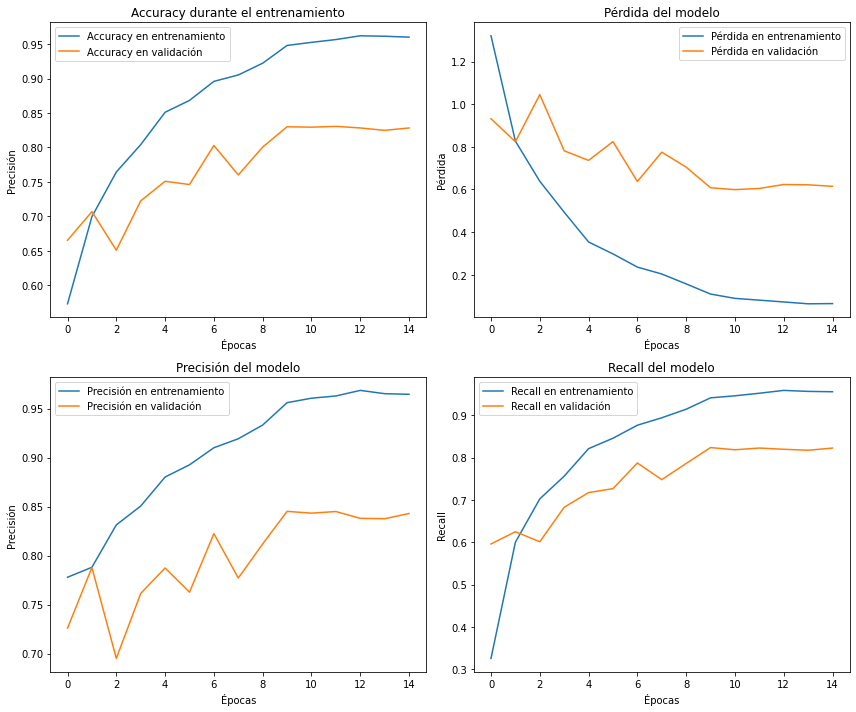

In [23]:
import matplotlib.pyplot as plt

# Establecer una figura para alojar los gráficos
plt.figure(figsize=(12, 10))  # Ajusta el tamaño según tus preferencias

# Gráfica de accuracy
plt.subplot(2, 2, 1)  # 2 filas, 2 columnas, primer gráfico
plt.plot(history.history['accuracy'], label='Accuracy en entrenamiento')
plt.plot(history.history['val_accuracy'], label='Accuracy en validación')
plt.title('Accuracy durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfica de pérdida
plt.subplot(2, 2, 2)  # 2 filas, 2 columnas, segundo gráfico
plt.plot(history.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en validación')
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Gráfica de precisión
plt.subplot(2, 2, 3)  # 2 filas, 2 columnas, tercer gráfico
plt.plot(history.history['precision'], label='Precisión en entrenamiento')
plt.plot(history.history['val_precision'], label='Precisión en validación')
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfica de recall
plt.subplot(2, 2, 4)  # 2 filas, 2 columnas, cuarto gráfico
plt.plot(history.history['recall'], label='Recall en entrenamiento')
plt.plot(history.history['val_recall'], label='Recall en validación')
plt.title('Recall del modelo')
plt.xlabel('Épocas')
plt.ylabel('Recall')
plt.legend()

# Mostrar los gráficos
plt.tight_layout()  # Ajusta el espacio entre los gráficos
plt.show()

### Evaluación

In [211]:
import numpy as np
from sklearn.metrics import confusion_matrix, recall_score, precision_score

# Evaluar el rendimiento del modelo en el conjunto de prueba
test_loss, test_acc, test_precision, test_recall, test_auc, test_f1 = model.evaluate(
    test_generator,  # Generador del conjunto de prueba
)

# Imprimir los resultados
print(f'Pérdida en el conjunto de prueba: {test_loss}')
print(f'accuracy en el conjunto de prueba: {test_acc}')
print(f'Precision en el conjunto de prueba: {test_precision}')
print(f'Recall en el conjunto de prueba: {test_recall}')
print(f'AUC en el conjunto de prueba: {test_auc}')
print(f'F1-Score en el conjunto de prueba: {test_f1}')

55/55 ━━━━━━━━━━━━━━━━━━━━ 141s 3s/step - accuracy: 0.7653 - auc: 0.9555 - f1_score: 0.9555 - loss: 0.7579 - precision: 0.7819 - recall: 0.7475
Pérdida en el conjunto de prueba: 0.5629568099975586
accuracy en el conjunto de prueba: 0.8140877485275269
Precision en el conjunto de prueba: 0.8309352397918701
Recall en el conjunto de prueba: 0.8002309203147888
AUC en el conjunto de prueba: 0.9721276760101318
F1-Score en el conjunto de prueba: 0.9721276760101318


55/55 ━━━━━━━━━━━━━━━━━━━━ 151s 3s/step


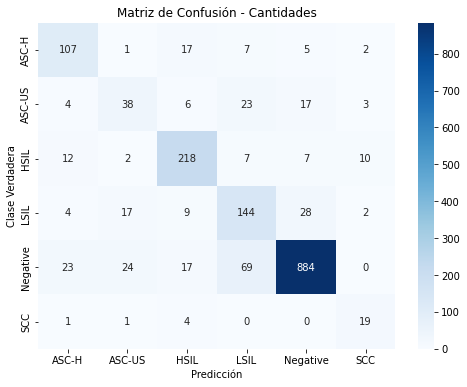

In [212]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Realizar predicciones en el conjunto de prueba
test_steps = int(np.ceil(test_generator.samples / test_generator.batch_size))
predictions = model.predict(test_generator, steps=test_steps)
predicted_classes = np.argmax(predictions, axis=1)

# Obtener las etiquetas verdaderas
true_classes = test_generator.classes

# Obtener las clases
class_labels = list(test_generator.class_indices.keys())

# Crear la matriz de confusión
cm = confusion_matrix(true_classes, predicted_classes)

# Crear la matriz de confusión normalizada (probabilidades)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Función para graficar la matriz de confusión
def plot_confusion_matrix(cm, class_labels, title='Matriz de Confusión', cmap='Blues', fmt='d'):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap=cmap, xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicción')
    plt.ylabel('Clase Verdadera')
    plt.title(title)
    plt.show()

# Graficar la matriz de confusión con cantidades
plot_confusion_matrix(cm, class_labels, title='Matriz de Confusión - Cantidades')

55/55 ━━━━━━━━━━━━━━━━━━━━ 54s 967ms/step


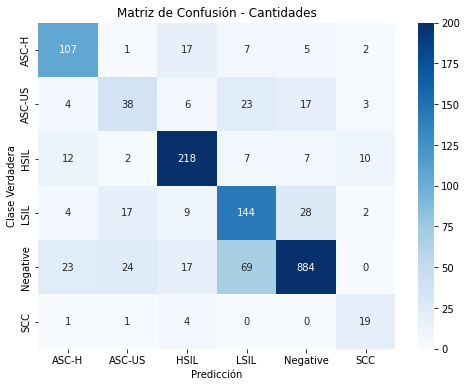

In [217]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Realizar predicciones en el conjunto de prueba
test_steps = int(np.ceil(test_generator.samples / test_generator.batch_size))
predictions = model.predict(test_generator, steps=test_steps)
predicted_classes = np.argmax(predictions, axis=1)

# Obtener las etiquetas verdaderas
true_classes = test_generator.classes

# Obtener las clases
class_labels = list(test_generator.class_indices.keys())

# Crear la matriz de confusión
cm = confusion_matrix(true_classes, predicted_classes)

# Crear la matriz de confusión normalizada (probabilidades)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Función para graficar la matriz de confusión con escala limitada
def plot_confusion_matrix(cm, class_labels, title='Matriz de Confusión', cmap='Blues', fmt='d', vmax=None):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap=cmap, xticklabels=class_labels, yticklabels=class_labels, vmax=vmax)
    plt.xlabel('Predicción')
    plt.ylabel('Clase Verdadera')
    plt.title(title)
    plt.show()

# Graficar la matriz de confusión con cantidades y escala limitada
plot_confusion_matrix(cm, class_labels, title='Matriz de Confusión - Cantidades', vmax=200)

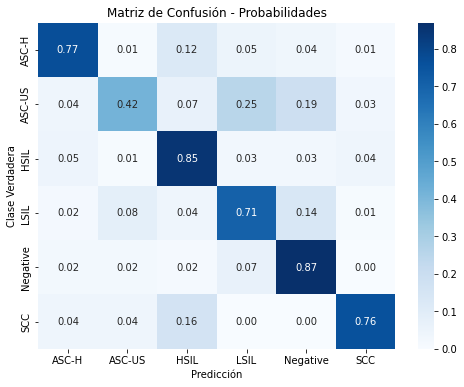

In [213]:
# Graficar la matriz de confusión con probabilidades
plot_confusion_matrix(cm_normalized, class_labels, title='Matriz de Confusión - Probabilidades', fmt='.2f')

In [214]:
# Reporte de clasificación
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

              precision    recall  f1-score   support

       ASC-H       0.71      0.77      0.74       139
      ASC-US       0.46      0.42      0.44        91
        HSIL       0.80      0.85      0.83       256
        LSIL       0.58      0.71      0.63       204
    Negative       0.94      0.87      0.90      1017
         SCC       0.53      0.76      0.62        25

    accuracy                           0.81      1732
   macro avg       0.67      0.73      0.69      1732
weighted avg       0.83      0.81      0.82      1732



55/55 ━━━━━━━━━━━━━━━━━━━━ 170s 3s/step


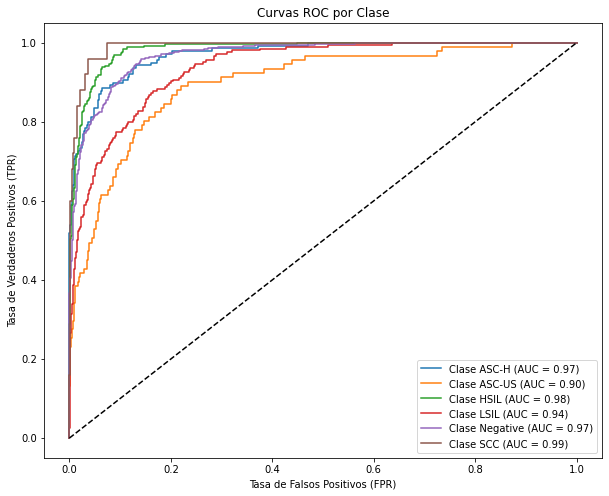

AUC Promedio: 0.96
AUC Promedio Ponderado: 0.96


In [215]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

# Obtener las probabilidades predichas
y_pred_proba = model.predict(test_generator)

# Obtener las etiquetas verdaderas y nombres de las clases
y_true = test_generator.classes  # Etiquetas verdaderas
class_names = list(test_generator.class_indices.keys())  # Nombres de las clases

# Convertir y_true a formato binario por clase
n_classes = len(class_names)
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

roc_auc = dict()

# Generar curvas ROC para cada clase
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Clase {class_names[i]} (AUC = {auc(fpr, tpr):.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Línea de referencia
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC por Clase')
plt.legend(loc='lower right')
plt.show()

# Calcular y mostrar el AUC promedio
auc_promedio = np.mean(list(roc_auc.values()))
print(f'AUC Promedio: {auc_promedio:.2f}')

# Calcular y mostrar el AUC promedio ponderado
auc_promedio_pond = roc_auc_score(y_true_bin, y_pred_proba, average='weighted', multi_class='ovr')
print(f'AUC Promedio Ponderado: {auc_promedio_pond:.2f}')

### Modelo guardado

55/55 ━━━━━━━━━━━━━━━━━━━━ 54s 961ms/step - accuracy: 0.7857 - auc: 0.9497 - f1_score: 0.9497 - loss: 0.7997 - precision: 0.8007 - recall: 0.7662
Precisión en el conjunto de prueba: 0.8314
Recall en el conjunto de prueba: 0.8187
Precision en el conjunto de prueba: 0.8456
AUC en el conjunto de prueba: 0.9691
F1-Score en el conjunto de prueba: 0.9690746665000916
55/55 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step
              precision    recall  f1-score   support

       ASC-H       0.68      0.81      0.74       139
      ASC-US       0.50      0.41      0.45        91
        HSIL       0.82      0.85      0.83       256
        LSIL       0.62      0.71      0.66       204
    Negative       0.95      0.89      0.92      1017
         SCC       0.51      0.72      0.60        25

    accuracy                           0.83      1732
   macro avg       0.68      0.73      0.70      1732
weighted avg       0.84      0.83      0.83      1732



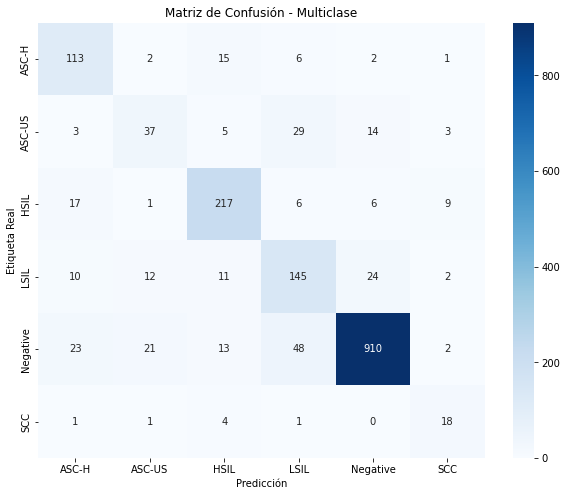

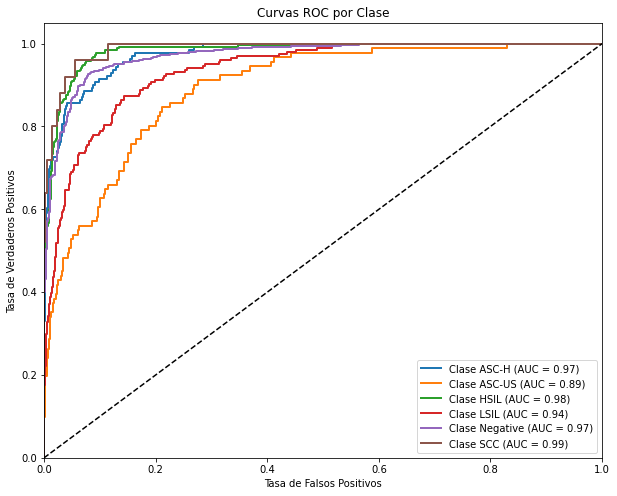

In [25]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

# Cargar el modelo guardado
model = tf.keras.models.load_model('modelosFinales/xception_clasificacion6clases.keras')

# Evaluar el modelo en el conjunto de prueba
evaluation_metrics = model.evaluate(test_generator)

# Asumiendo que tienes 5 métricas (loss, accuracy, precision, recall, auc)
test_loss, test_acc, test_precision, test_recall, test_auc, test_f1 = evaluation_metrics
print(f"Precisión en el conjunto de prueba: {test_acc:.4f}")
print(f"Recall en el conjunto de prueba: {test_recall:.4f}")
print(f"Precision en el conjunto de prueba: {test_precision:.4f}")
print(f"AUC en el conjunto de prueba: {test_auc:.4f}")
print(f'F1-Score en el conjunto de prueba: {test_f1}')

# Generar predicciones y etiquetas verdaderas
y_pred_prob = model.predict(test_generator)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = test_generator.classes

# Nombres de las clases
class_labels = list(test_generator.class_indices.keys())

# Reporte de clasificación
print(classification_report(y_true, y_pred, target_names=class_labels))

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Matriz de Confusión - Multiclase')
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Real')
plt.show()

# Curvas ROC y precisión-recall para cada clase con el mejor threshold
best_thresholds = {}

# Curvas ROC por clase
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(class_labels)):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i, label in enumerate(class_labels):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Clase {label} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curvas ROC por Clase')
plt.legend(loc='lower right')
plt.show()
